### Libraries

In [122]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import re
from math import log
import csv
import matplotlib.dates as mdates
import seaborn as sns

# Metric: Transaction Response Times (TRT) in ms

## Formatting

#### CSV

In [123]:
def process_file_data_to_csv(filename):

    timestamps = []
    data_rows = []

    storedprocs = ["neword", "payment", "delivery", "slev", "ostat"]

    with open(filename, "r") as file:
        for line in file:
            # Extract time intervals
            if "PERCENTILES" in line:
                timestamp = line.split()[3]
                if timestamp not in timestamps:
                    timestamps.append(timestamp)

            for storedproc in storedprocs:
                if f"|{storedproc}|" in line.lower():
                    min_val = re.search(r"MIN-([0-9.]+)", line).group(1)
                    p50_val = re.search(r"P50%-([0-9.]+)", line).group(1)
                    p95_val = re.search(r"P95%-([0-9.]+)", line).group(1)
                    p99_val = re.search(r"P99%-([0-9.]+)", line).group(1)
                    max_val = re.search(r"MAX-([0-9.]+)", line).group(1)

                    data_rows.append(
                        {
                            "Timestamp": timestamp,
                            "Transaction_Type": storedproc.upper(),
                            "MIN": min_val,
                            "P50%": p50_val,
                            "P95%": p95_val,
                            "P99%": p99_val,
                            "MAX": max_val,
                        }
                    )

    df = pd.DataFrame(data_rows)

    output_filename = filename.replace(".log", ".csv")
    df.to_csv(output_filename, index=False)

    print(f"Processed data has been saved to {output_filename}")


# Sample filename usage
filename = "TRT/filtered_transaction_data.log"
process_file_data_to_csv(filename)

Processed data has been saved to TRT/filtered_transaction_data.csv


## Preprocessing 

#### NEWORD P50% Percentile in ms on logarithmic scale

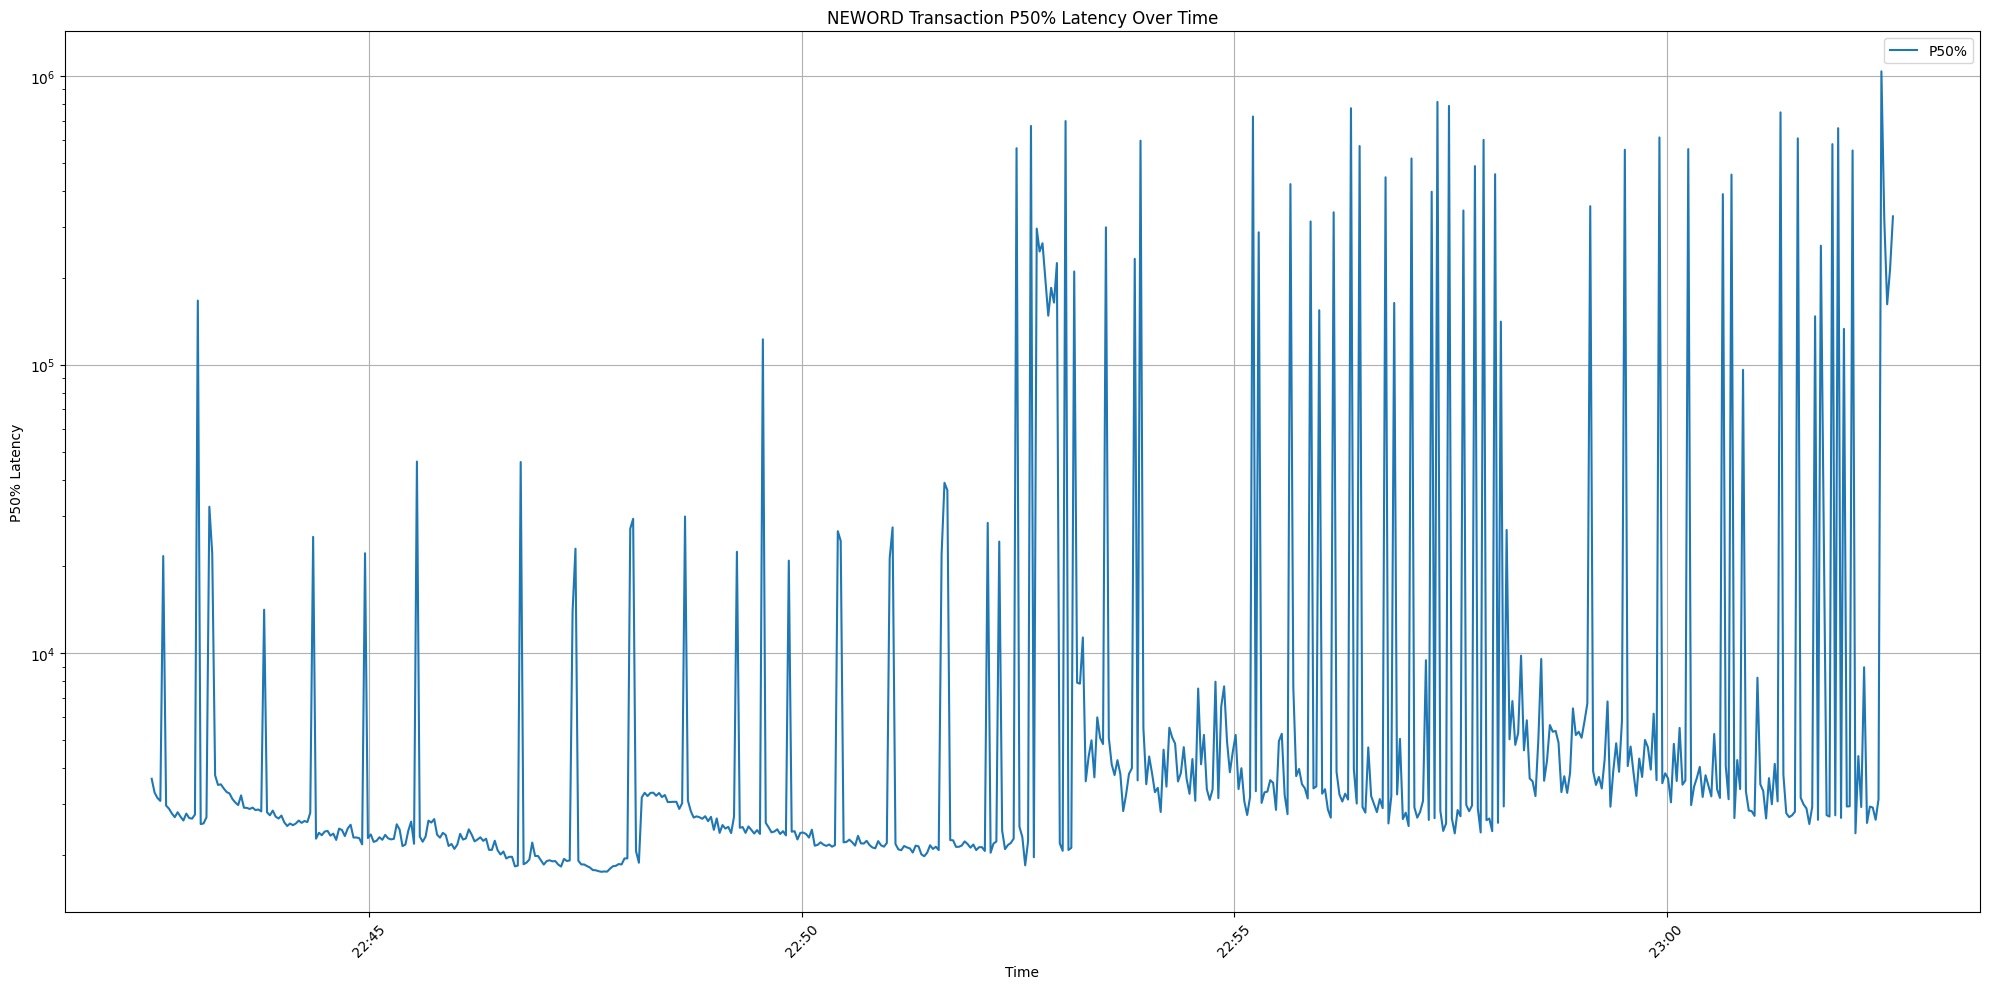

In [124]:
trt_df = pd.read_csv('TRT/filtered_transaction_data.csv')
neword_df = trt_df[trt_df['Transaction_Type'] == 'NEWORD'].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(
    neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-"
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.yscale('log')
plt.tight_layout()

plt.legend()
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time_log.png")
plt.show()

#### NEWORD P50% Percentile in ms 

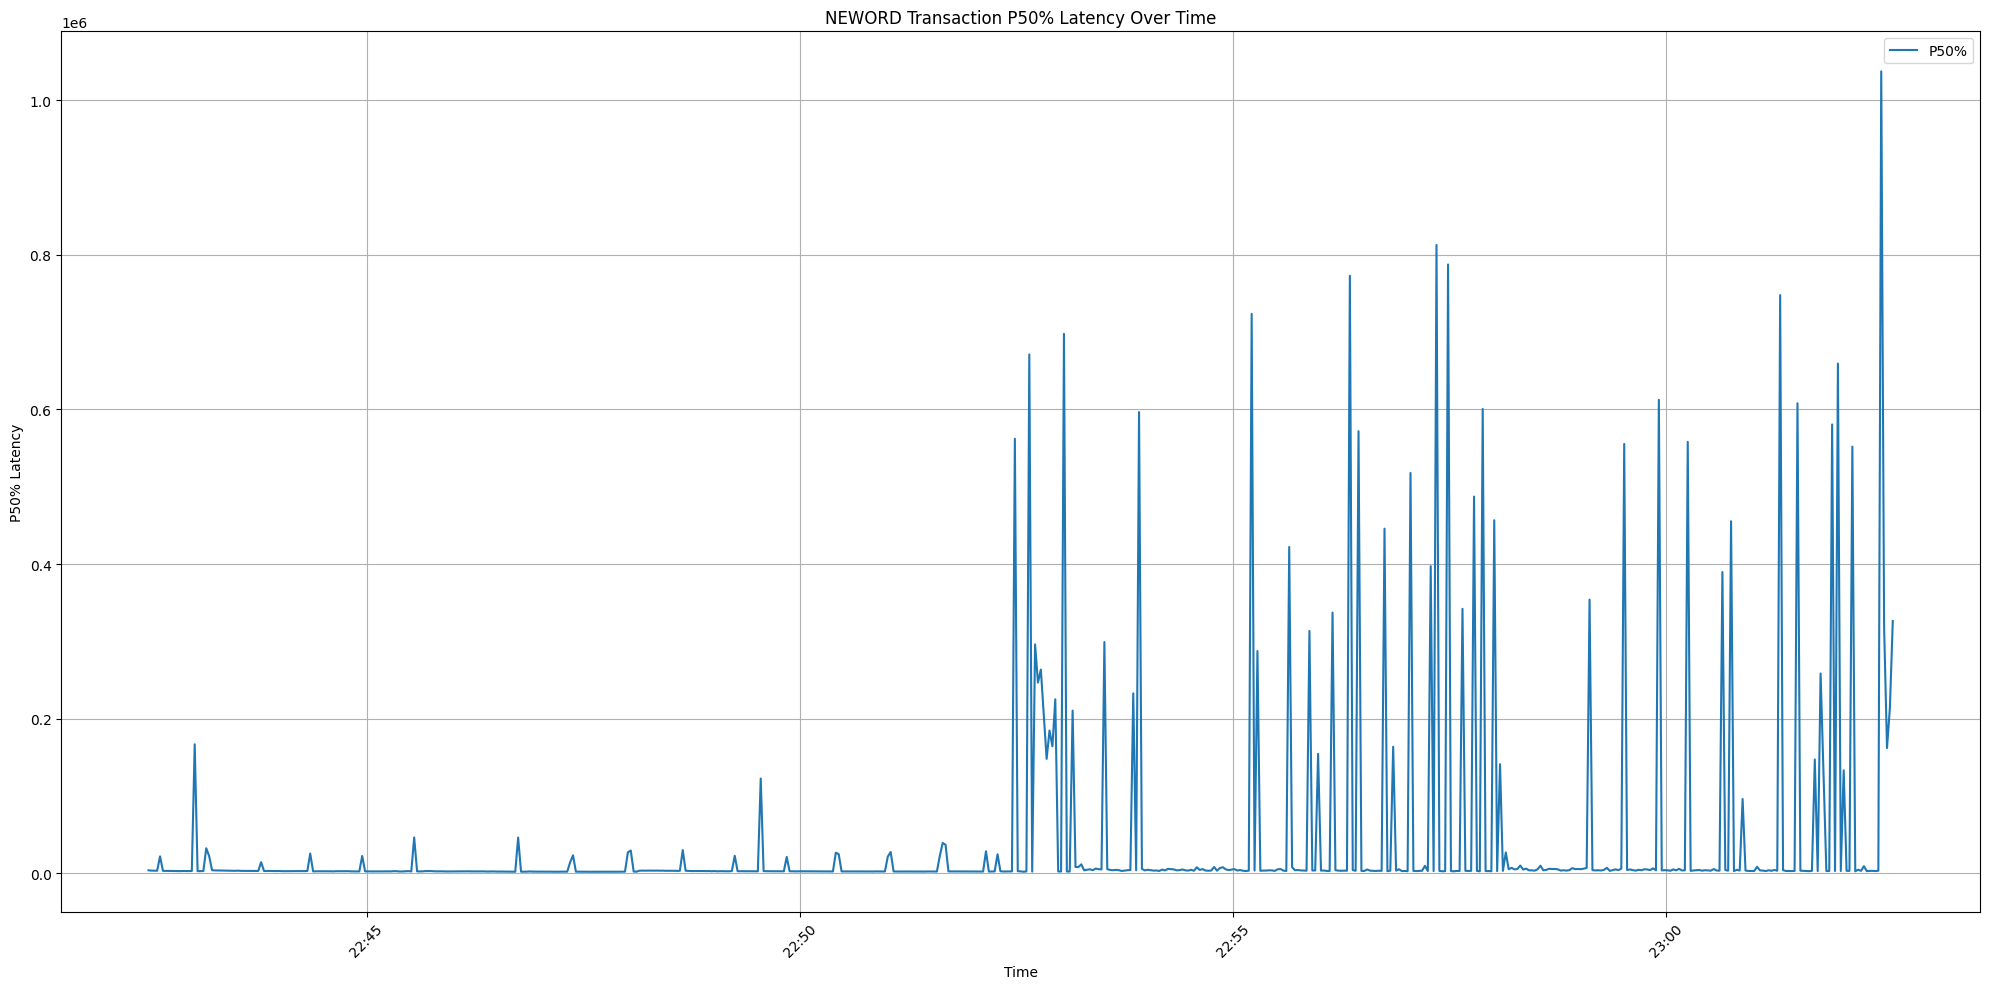

In [125]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time.png")
plt.show()

#### NEWORD P95% Percentile in ms

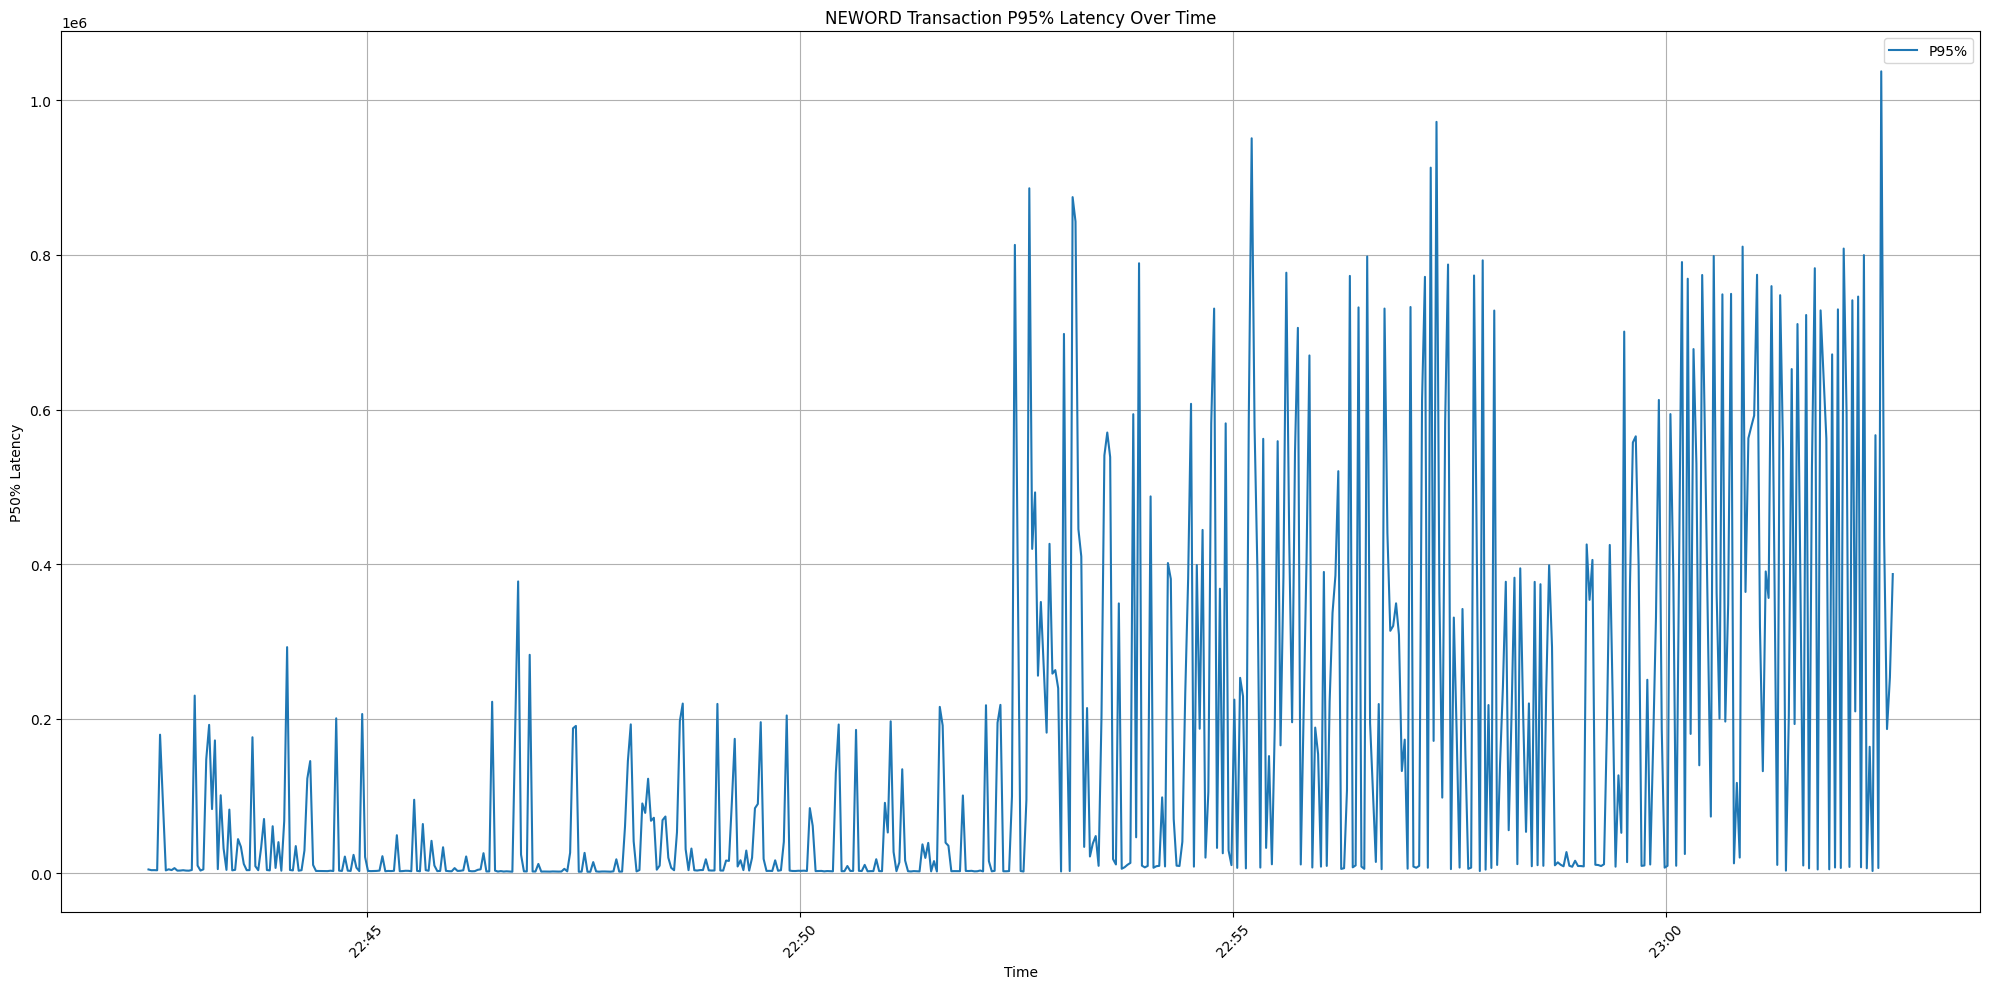

In [126]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()
plt.savefig("TRT/Plots/NEWORD_P95_Latency_Over_Time.png")
plt.show()

#### NEWORD P95% Percentile in ms on logarithmic scale

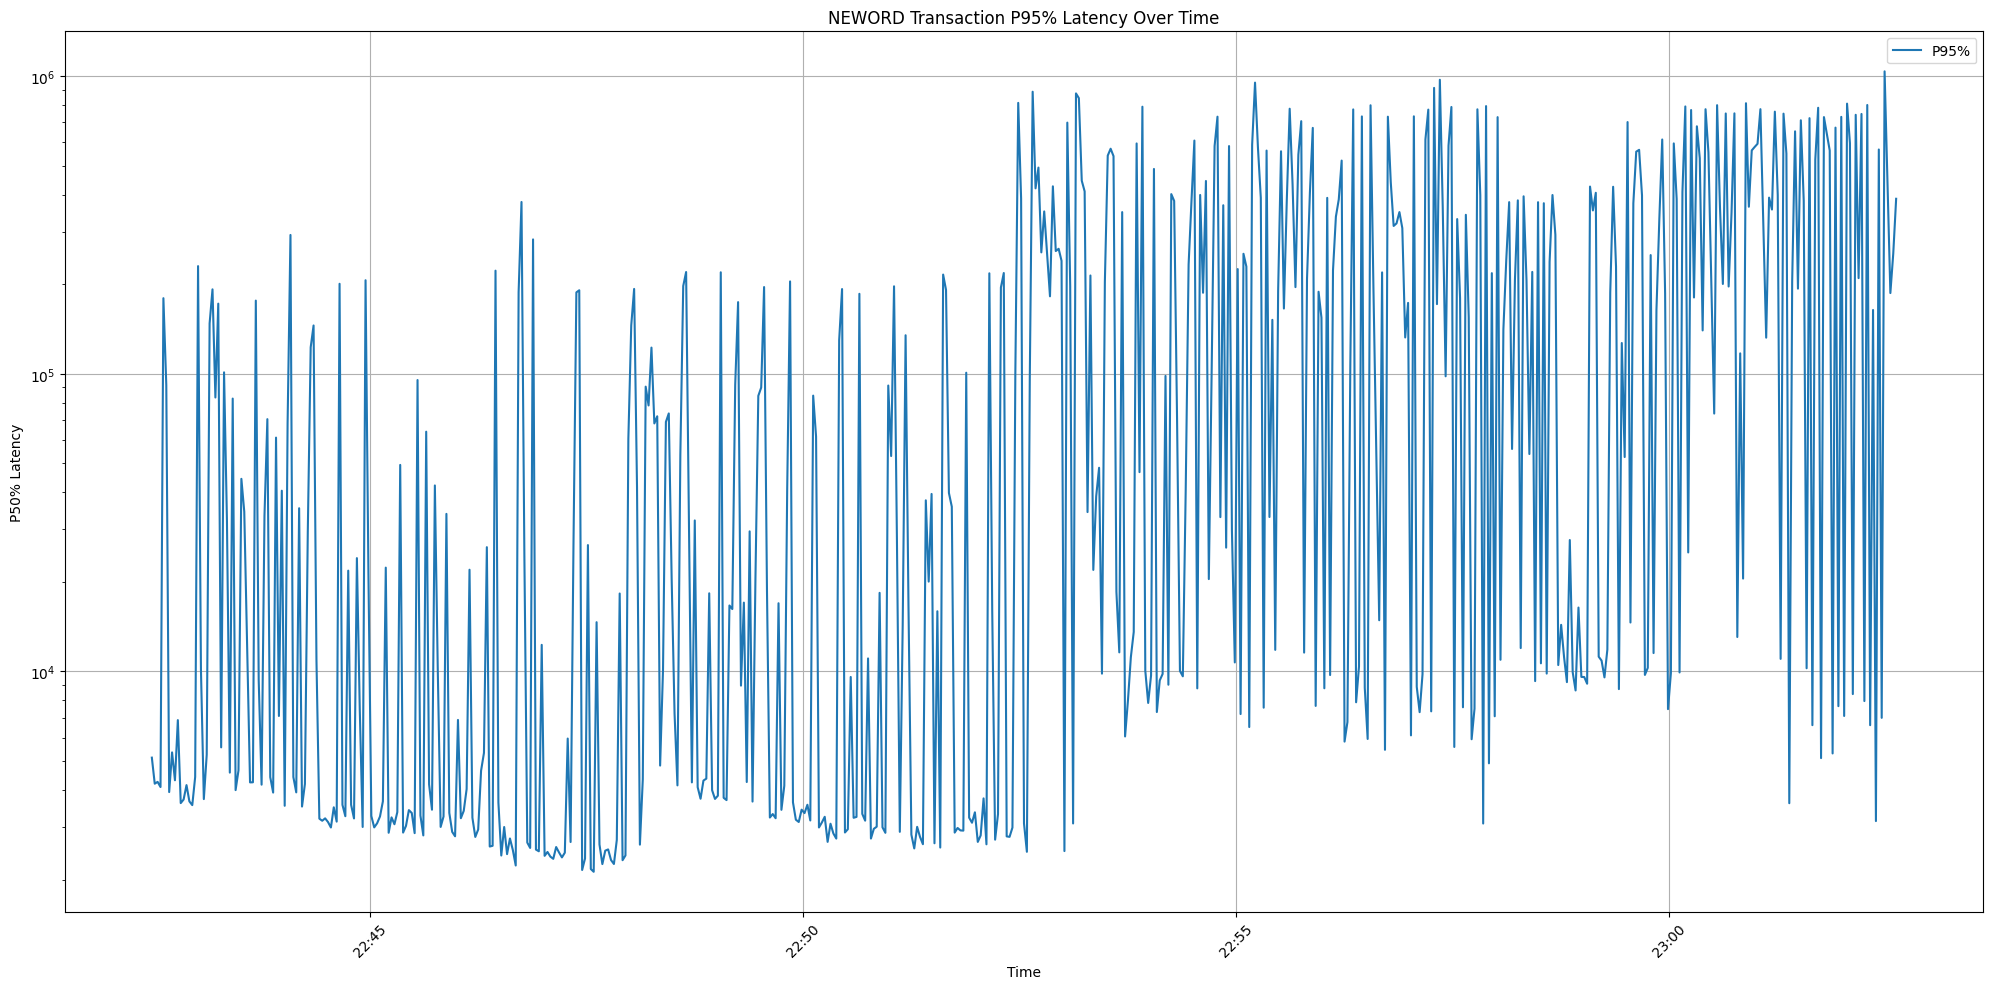

In [127]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.yscale('log')

plt.legend()
plt.savefig("TRT/Plots/NEWORD_P95_Latency_Over_Time_log.png")
plt.show()

## Statistical Analysis (only done for Metric: TRT (ms))

#### Slicing of time-series at known change points

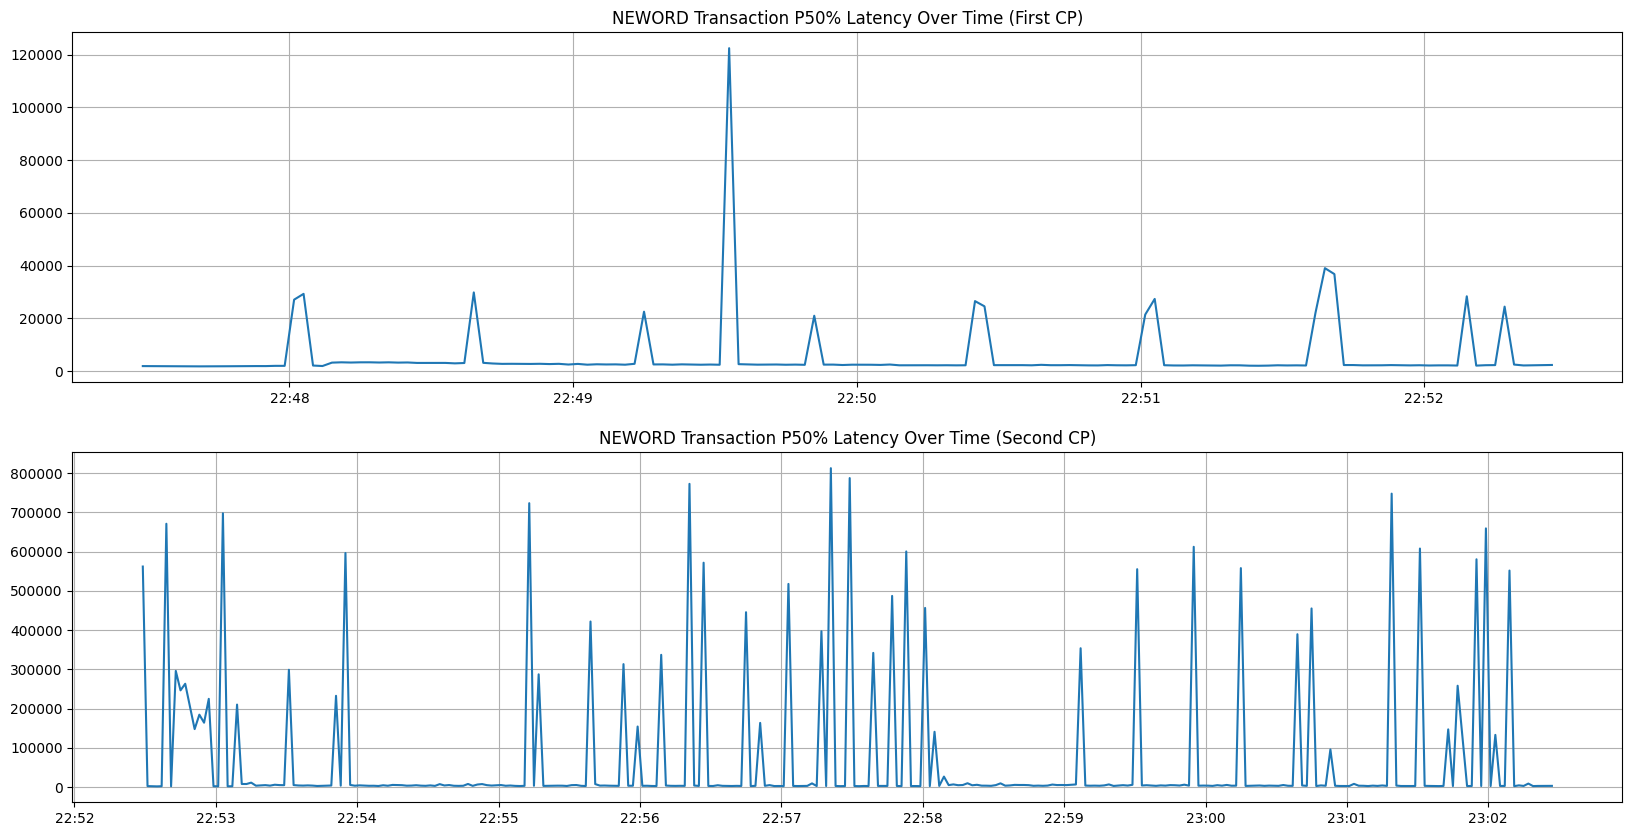

In [128]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10))]
df_2ndCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20))]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time_First_CP.png")

# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("NEWORD Transaction P50% Latency Over Time (Second CP)")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time_Second_CP.png")

#### Calculating mean, variance and standard deviation of time-series before and after change points 

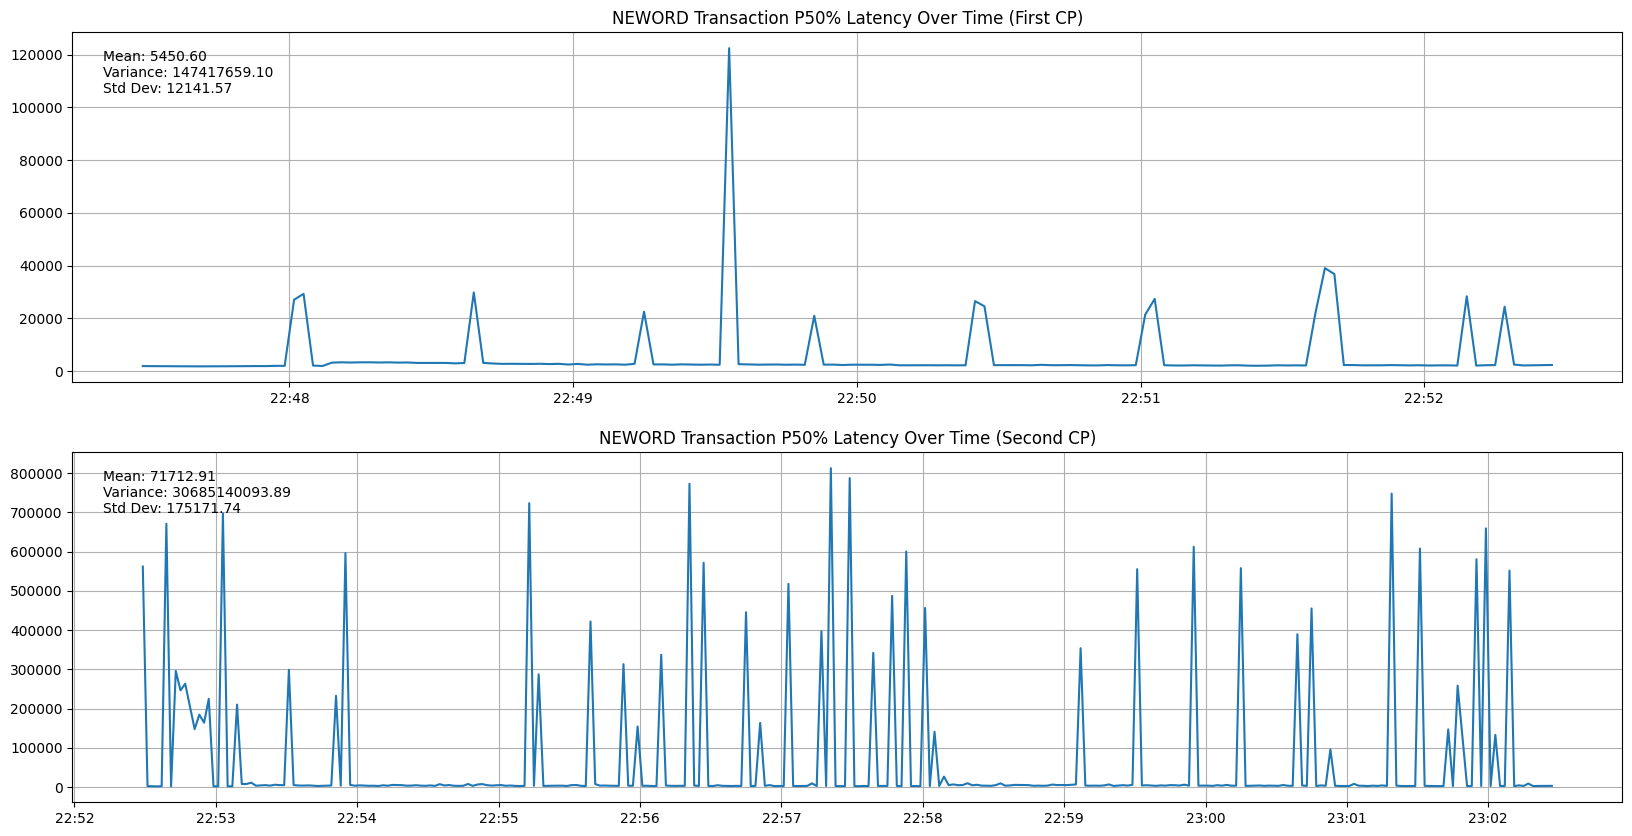

In [129]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5))
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10))
]
df_2ndCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10))
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20))
]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)

# Stats 1
mean = df_firstCP["P50%"].mean()
variance = df_firstCP["P50%"].var()
std_dev = df_firstCP["P50%"].std()
axs[0].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[0].transAxes, verticalalignment='top')
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time_First_CP_Stats.png")

# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("NEWORD Transaction P50% Latency Over Time (Second CP)")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)

# Stats 2
mean = df_2ndCP["P50%"].mean()
variance = df_2ndCP["P50%"].var()
std_dev = df_2ndCP["P50%"].std()
axs[1].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[1].transAxes, verticalalignment='top')
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Over_Time_Second_CP_Stats.png")

## CPD

#### PELT

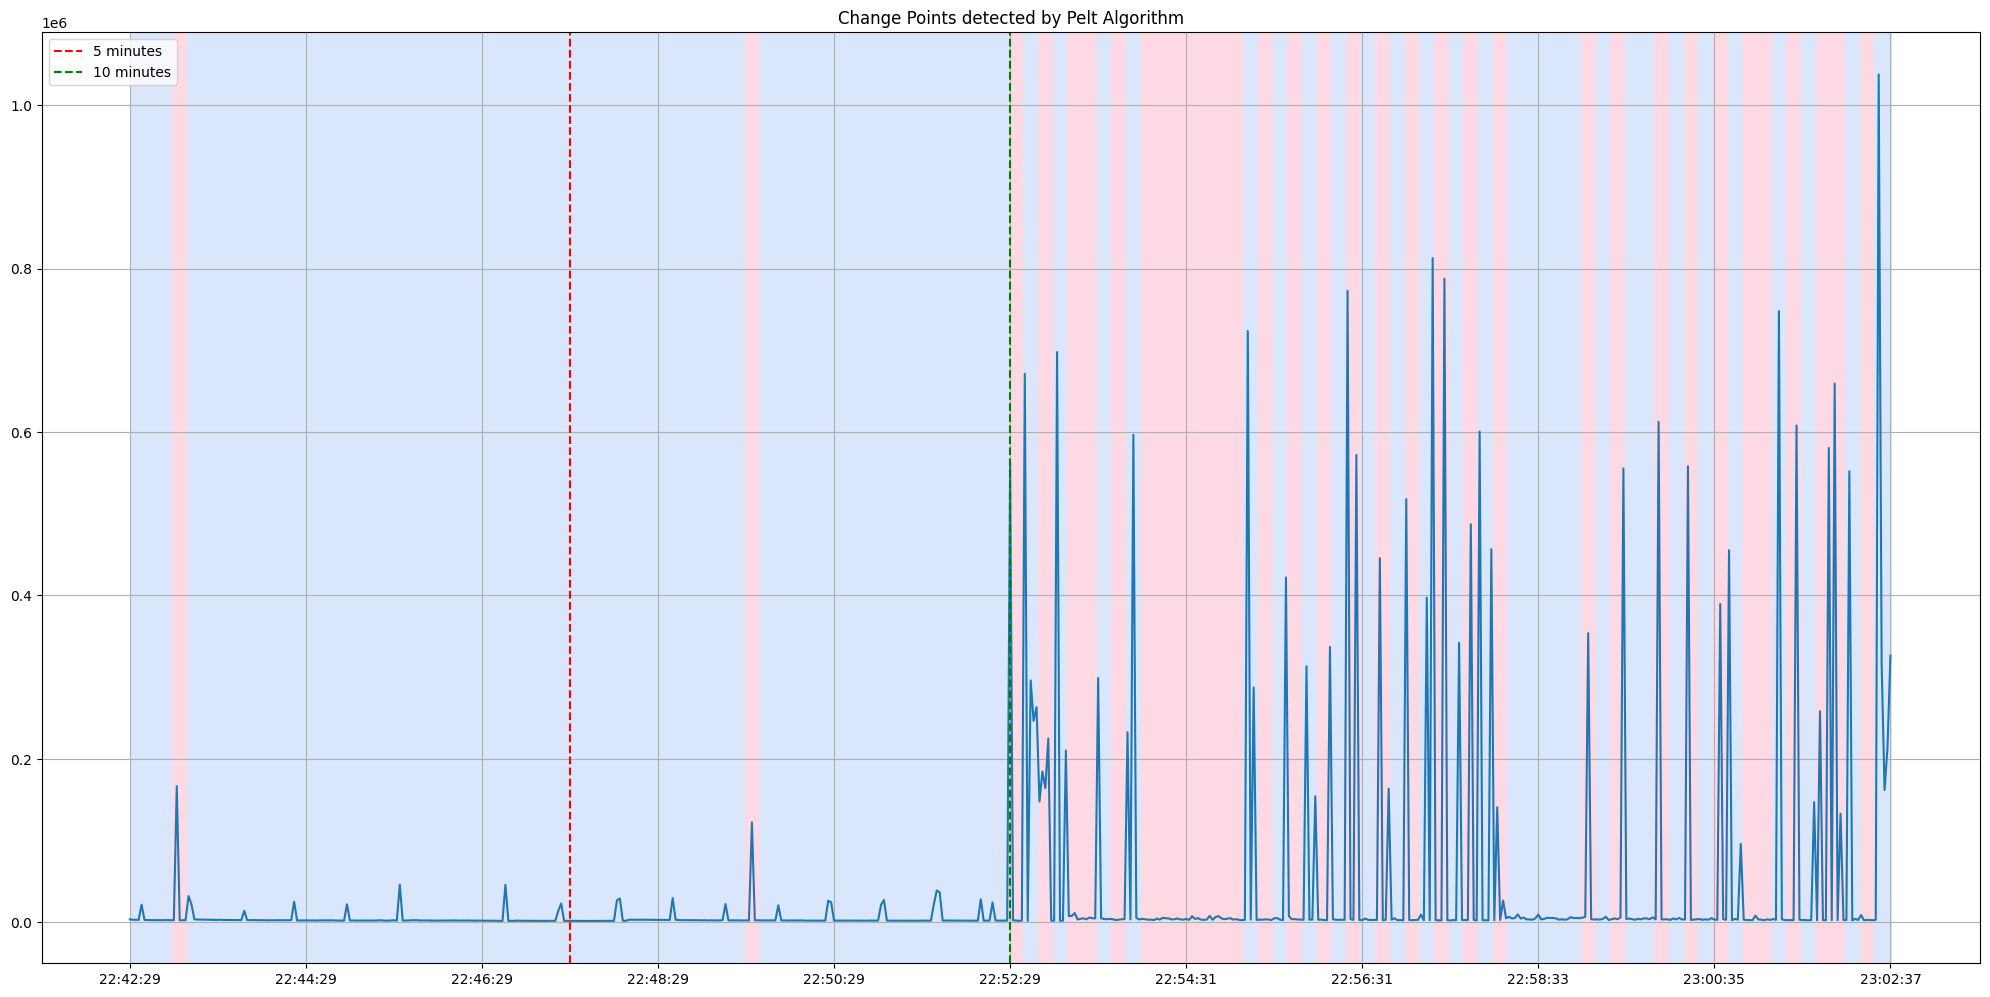

In [130]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

start_time = neword_df["Timestamp"].iloc[0]

five_minutes = (start_time + pd.Timedelta(minutes=5)).time()
ten_minutes = (start_time + pd.Timedelta(minutes=10)).time()
# Modeling
signal = neword_df["P50%"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)   

result = algo.predict(pen=999999990)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= five_minutes:
        plt.axvline(x=i, color="r", linestyle="--", label="5 minutes")
        break

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= ten_minutes:
        plt.axvline(x=i, color="g", linestyle="--", label="10 minutes")
        break

plt.xticks(ticks=range(0, len(signal), len(signal) // 10),labels=neword_df["Timestamp"].dt.time.astype(str).values[:: len(signal) // 10],)
plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
plt.grid(True)
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Change_Points_Pelt.png")
plt.show()

In [131]:
from datetime import datetime, timedelta, date

first_changepoint = False
second_changepoint = False

# Subtract 1 from each index in result to match indices in neword_df
adjusted_result = [idx - 1 for idx in result]

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(neword_df["Timestamp"]):
        changepoint_timestamp = neword_df["Timestamp"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp.strftime("%H:%M:%S"))
    else:
        print(f"Index {idx} is out of bounds for 'Timestamp'")
for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint = datetime.strptime(changepoint, "%H:%M:%S").time()

    # Calculate the difference in seconds between changepoint and five_minutes
    difference_five = datetime.combine(date.min, changepoint) - datetime.combine(
        date.min, five_minutes
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint) - datetime.combine(
        date.min, ten_minutes
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Changepoint detected at 22:52:27
Changepoint detected at 22:52:37
Result: FALSE


#### DP (with know and unknown change points passed as argument)

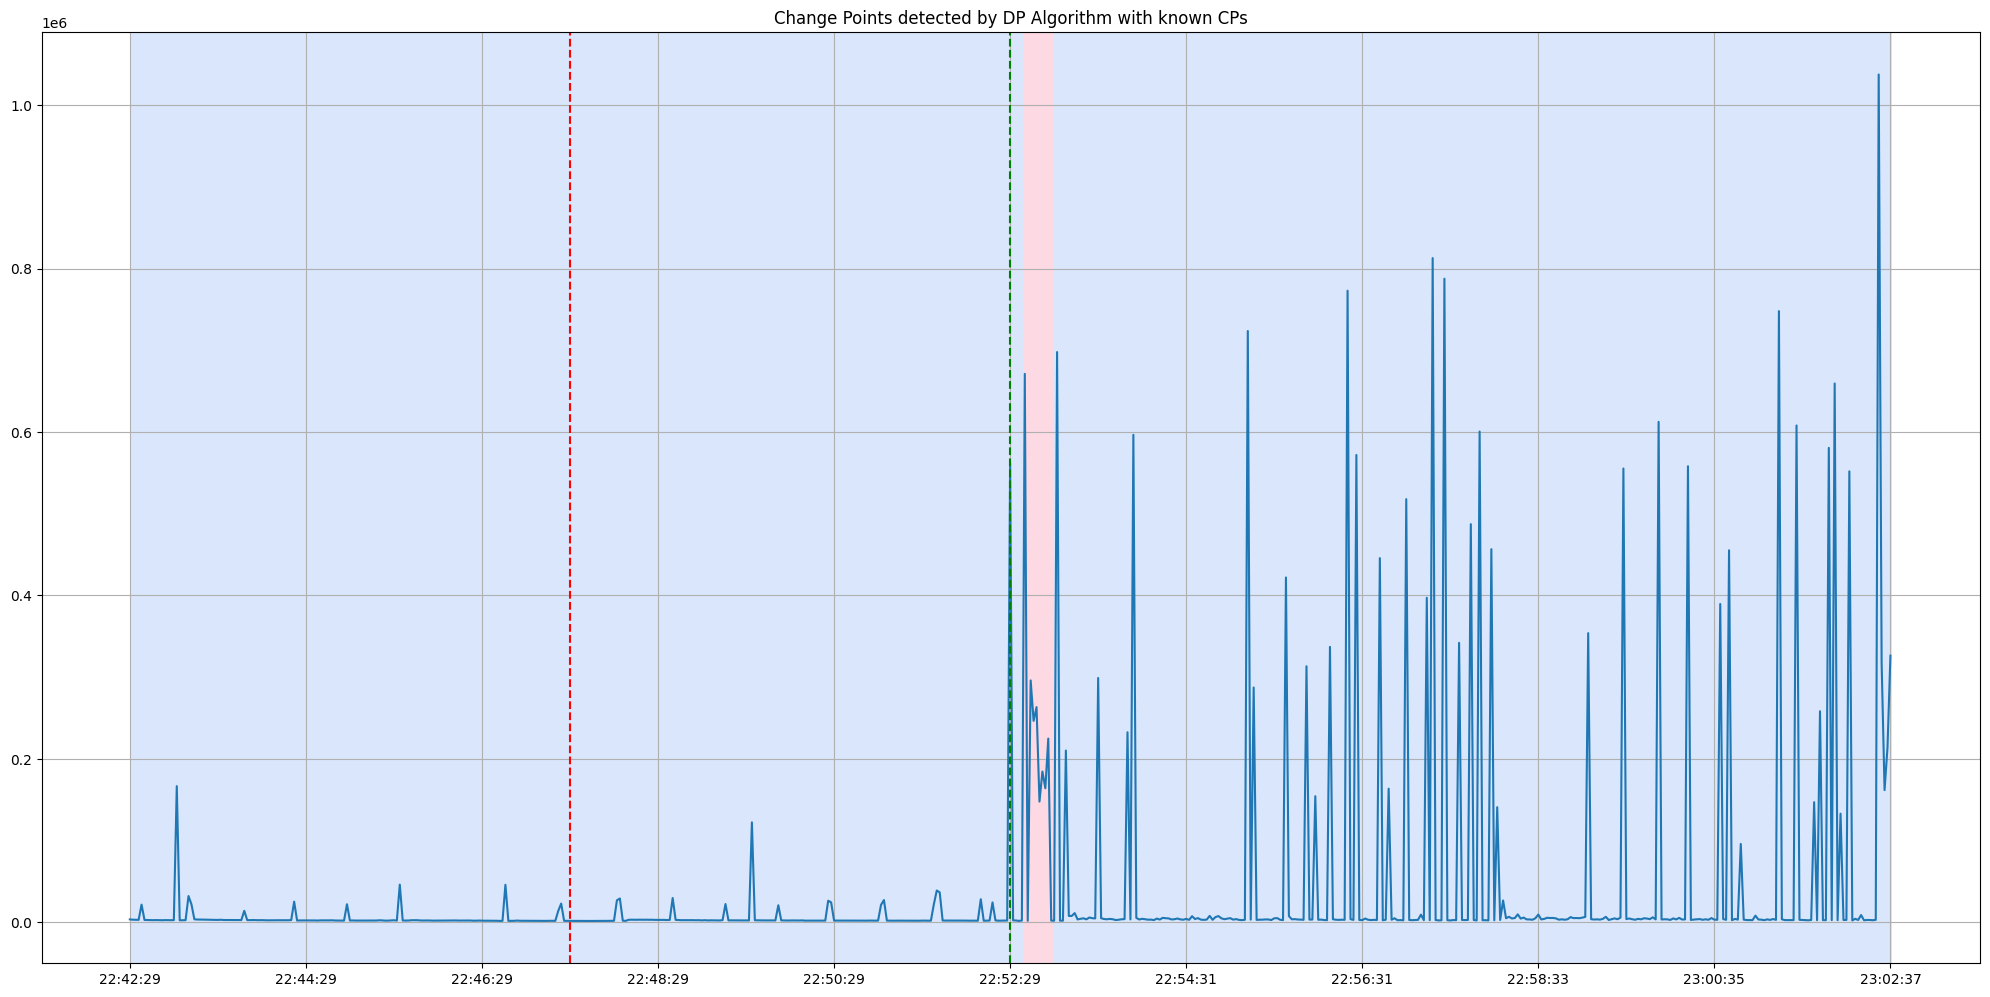

In [132]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Modeling
signal = neword_df["P50%"].values
model = "l1"  # euclidean distance
algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= five_minutes:
        plt.axvline(x=i, color="r", linestyle="--", label="5 minutes")
        break

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= ten_minutes:
        plt.axvline(x=i, color="g", linestyle="--", label="10 minutes")
        break

plt.xticks(ticks=range(0, len(signal), len(signal) // 10),labels=neword_df["Timestamp"].dt.time.astype(str).values[:: len(signal) // 10],)

plt.title("Change Points detected by DP Algorithm with known CPs")
plt.grid(True)
plt.savefig("TRT/Plots/NEWORD_P50_Latency_Change_Points_DP.png")
plt.show()

In [133]:
from datetime import datetime, timedelta, date

first_changepoint = False
second_changepoint = False

# Subtract 1 from each index in result to match indices in neword_df
adjusted_result = [idx - 1 for idx in result]

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(neword_df["Timestamp"]):
        changepoint_timestamp = neword_df["Timestamp"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp.strftime("%H:%M:%S"))
    else:
        print(f"Index {idx} is out of bounds for 'Timestamp'")
for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint = datetime.strptime(changepoint, "%H:%M:%S").time()

    # Calculate the difference in seconds between changepoint and five_minutes
    difference_five = datetime.combine(date.min, changepoint) - datetime.combine(
        date.min, five_minutes
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint) - datetime.combine(
        date.min, ten_minutes
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Changepoint detected at 22:52:37
Result: FALSE


# Metric: SYS-resources (CPU & memory)

## PreProcessing

In [134]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df["Memory Usage (current)"] = df["Memory Usage (current)"].str.replace("GB", "")
df["Memory Usage (peak)"] = df["Memory Usage (peak)"].str.replace("GB", "")

#### CPU usage (%) on logarithmic scale

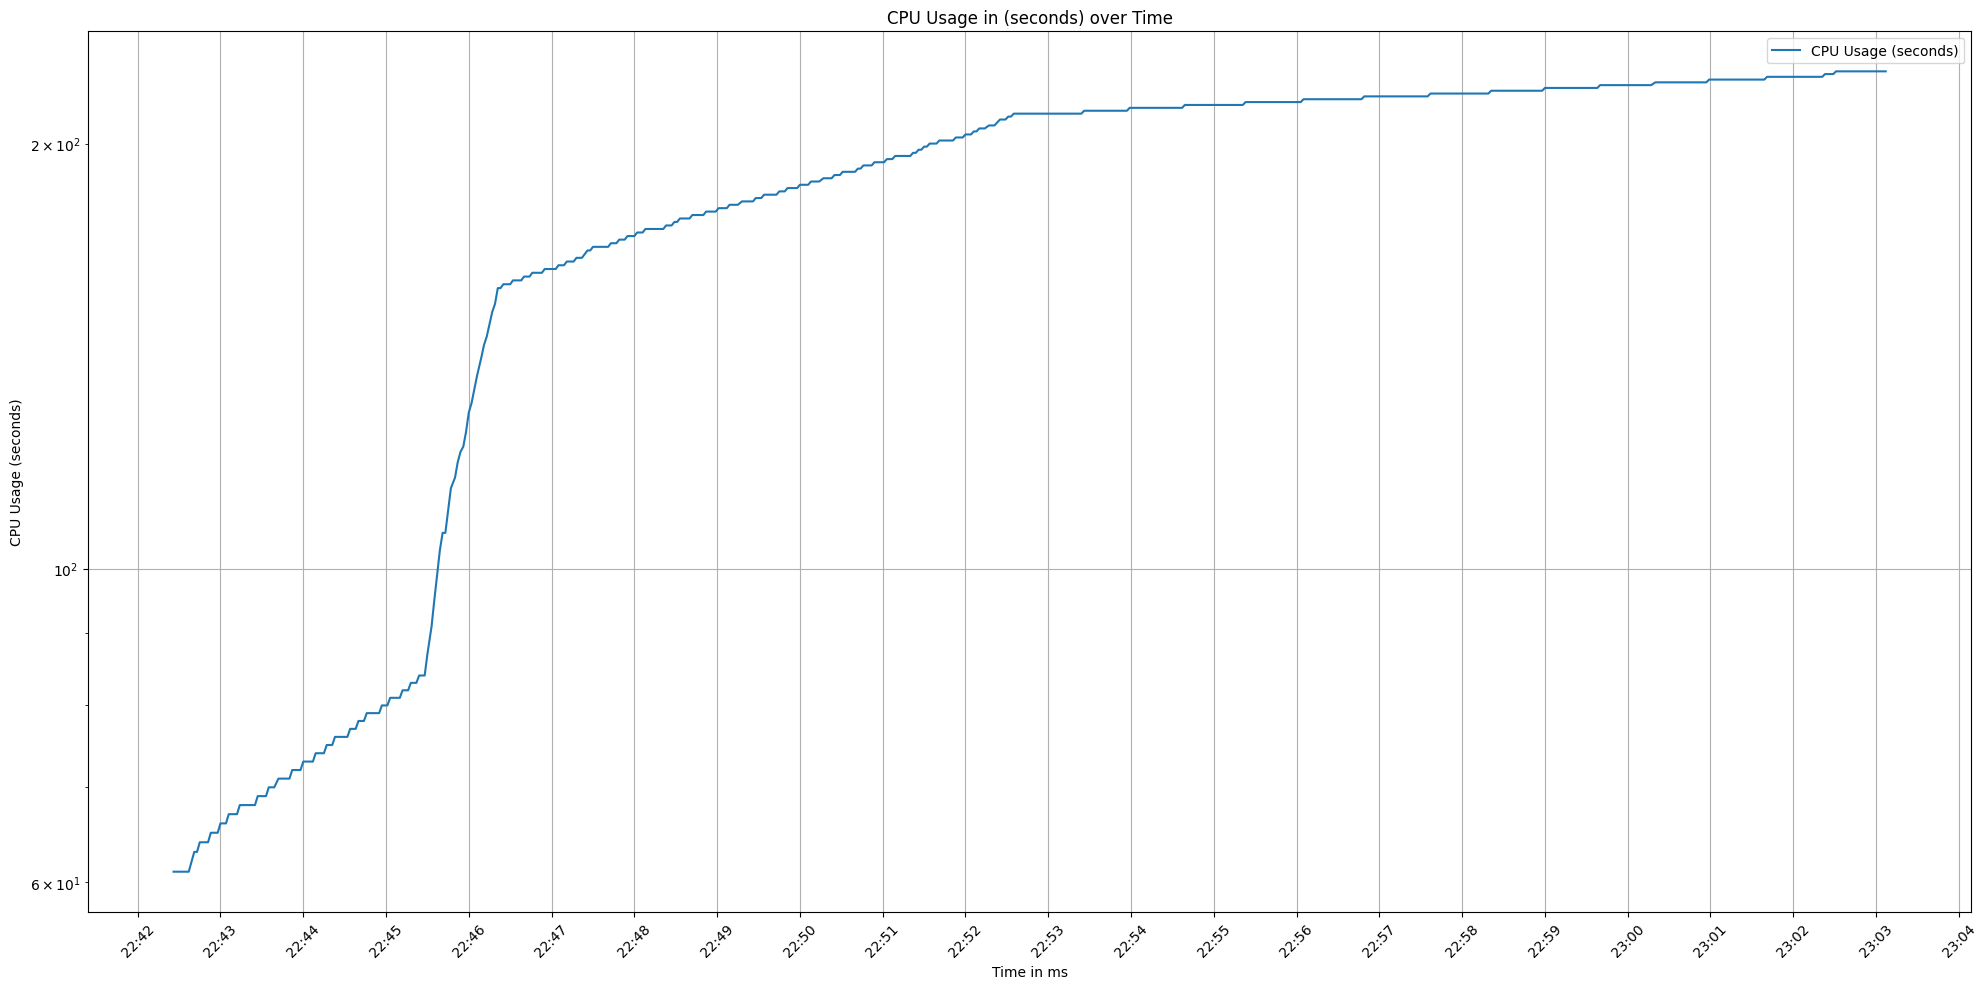

In [135]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df['CPU Usage (seconds)'] = df['CPU Usage (seconds)']
df['Time'] = pd.to_datetime(df['Time'])

cpu_df = df[['Time', 'CPU Usage (seconds)']].copy()

# print(cpu_df.head(5))

plt.figure(figsize=(20, 10))

plt.plot(cpu_df["Time"], cpu_df["CPU Usage (seconds)"], linestyle="-", label="CPU Usage (seconds)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

plt.xticks(rotation=45)

plt.xlabel("Time in ms")
plt.ylabel("CPU Usage (seconds)")
plt.title("CPU Usage in (seconds) over Time")

plt.grid(True)
plt.yscale("log")

plt.tight_layout()

plt.legend()
plt.savefig("SYS/Plots/CPU_Usage_Over_Time_log.png")
plt.show()

#### Memory usage (%)

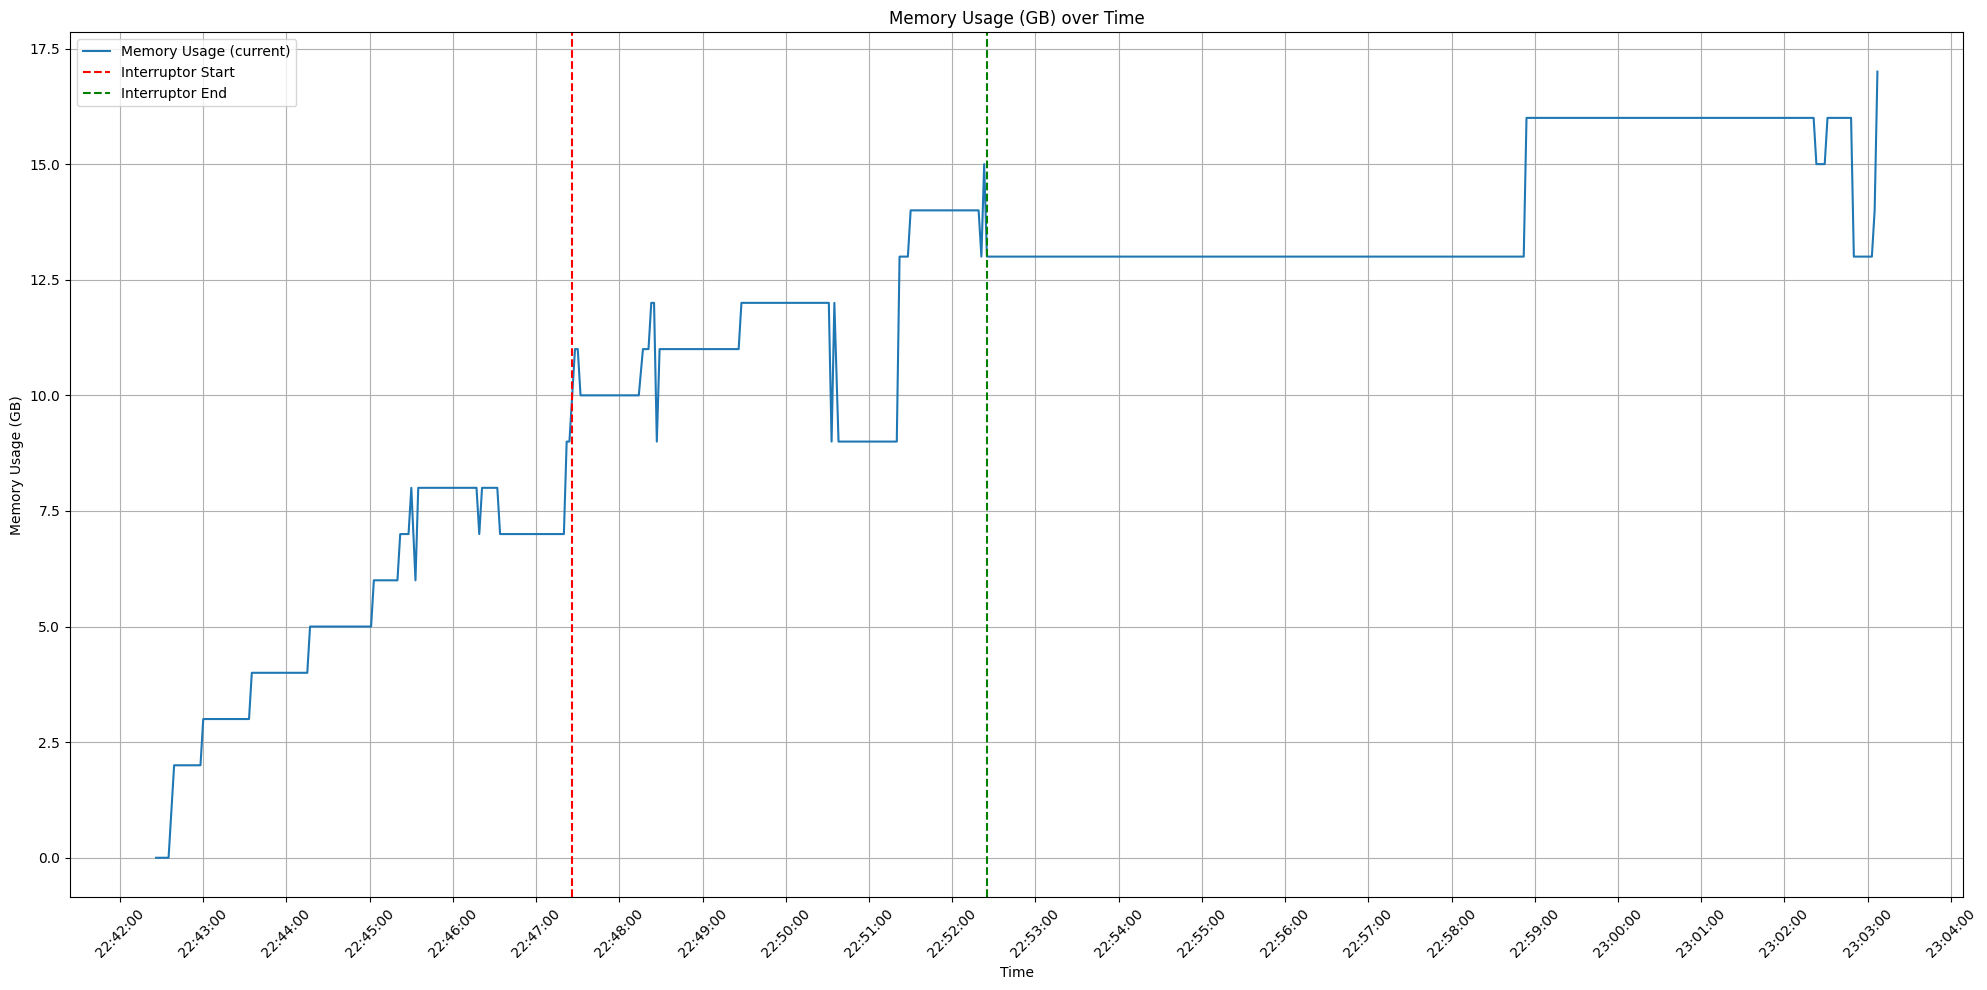

In [136]:
df = pd.read_csv("SYS/lxc_container_stats.csv")

df.columns = df.columns.str.strip()

df['Memory Usage (current)'] = df['Memory Usage (current)']
df["Time"] = pd.to_datetime(df["Time"])

mem_df = df[['Time', 'Memory Usage (current)']].copy()

start = mem_df["Time"].min()
time_5 = start + pd.Timedelta(minutes=5)
time_10 = start + pd.Timedelta(minutes=10)

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

# print(mem_df.head(5))

plt.figure(figsize=(20, 10))

plt.plot(mem_df["Time"], mem_df["Memory Usage (current)"], linestyle="-", label="Memory Usage (current)")

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

plt.axvline(x=exact_time_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=exact_time_10min, color="g", linestyle="--", label="Interruptor End")

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("Memory Usage (GB)")
plt.title("Memory Usage (GB) over Time")


plt.grid(True)
plt.yscale("linear")
plt.tight_layout()
plt.savefig("SYS/Plots/Memory_Usage_Over_Time.png")
plt.legend()

plt.show()

## CPD

#### PELT for memory usage

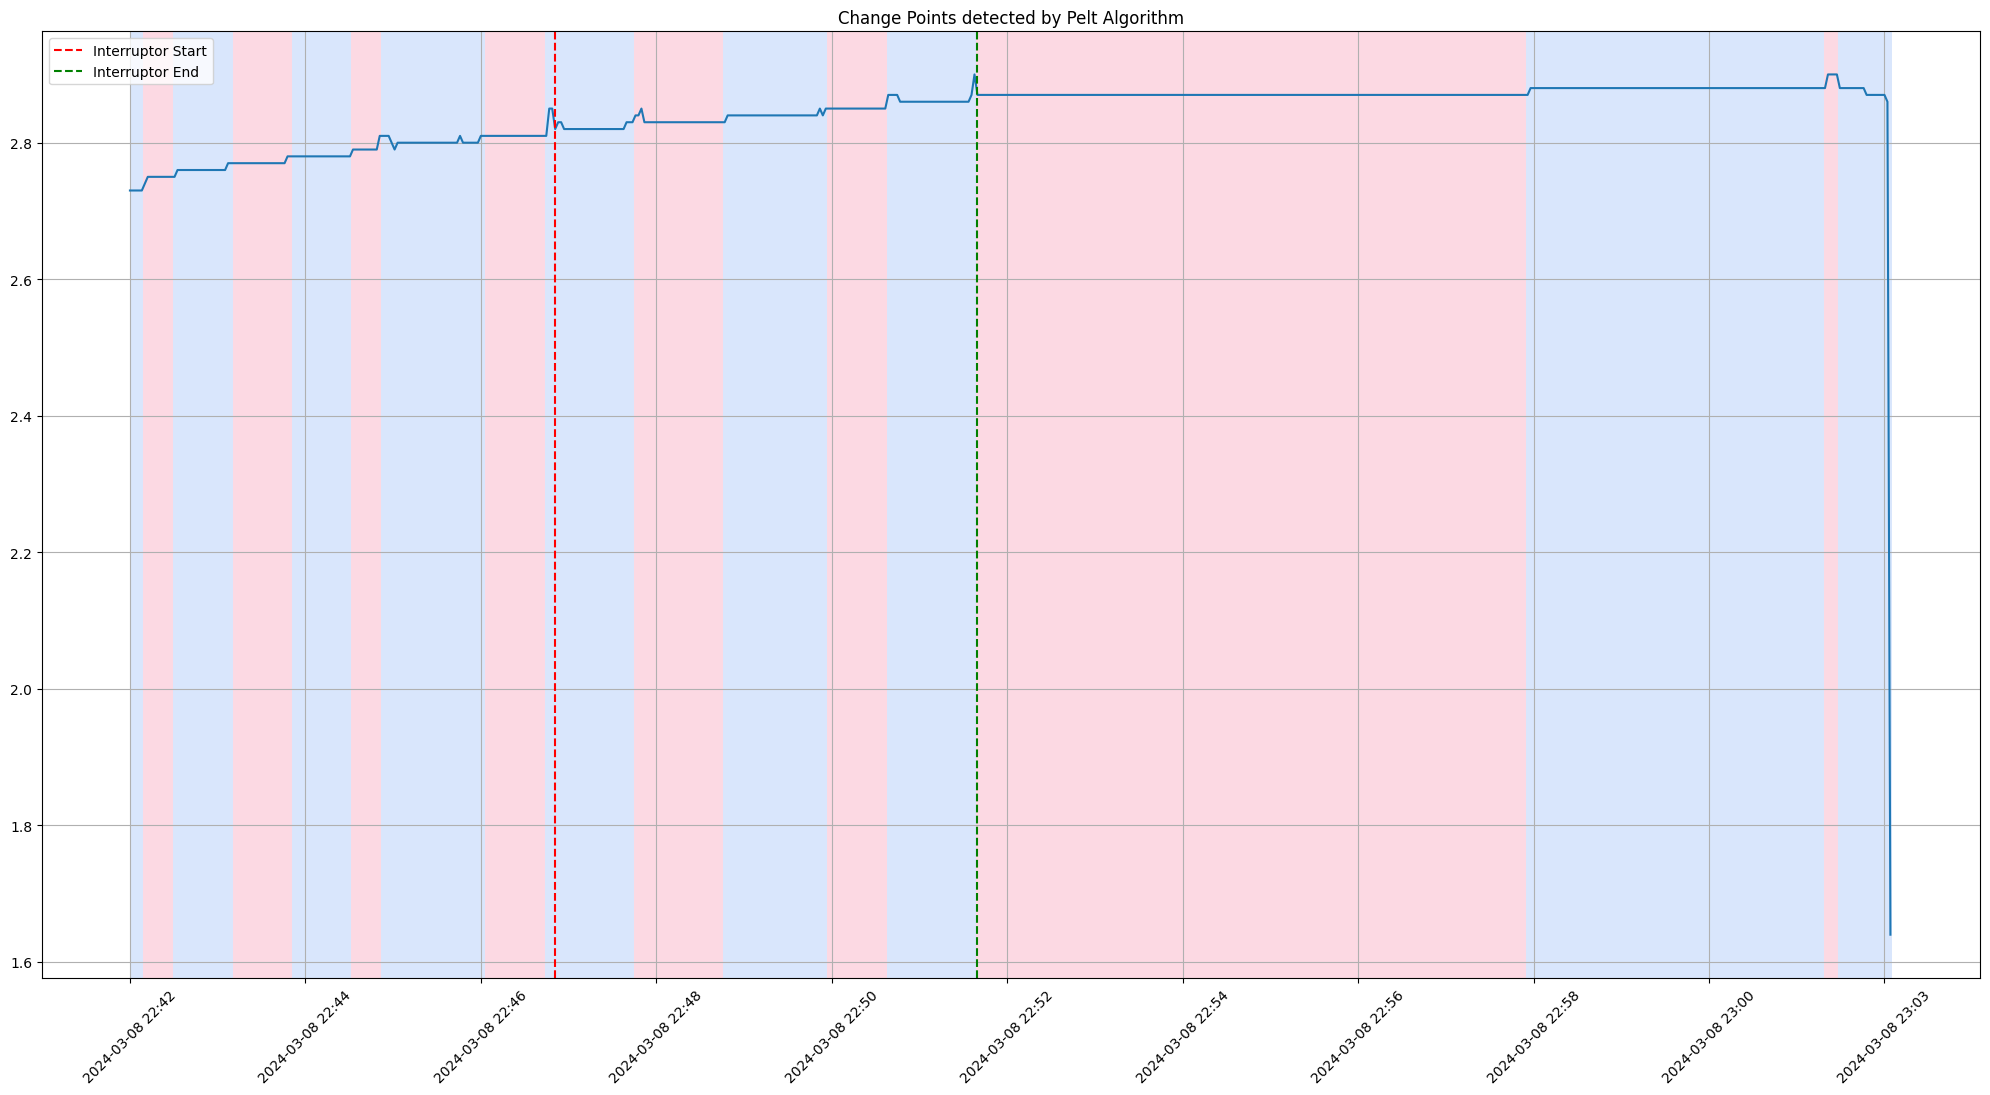

In [137]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df["Time"] = df["Time"].str.strip()
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

df["Memory Usage (current)"] = pd.to_numeric(df["Memory Usage (current)"].str.replace("GB", ""))
df["Memory Usage (peak)"] = pd.to_numeric(df["Memory Usage (peak)"].str.replace("GB", ""))

time_labels = df["Time"].values
indices = np.arange(len(signal))

start_time = df["Time"].min()
exact_time_5min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

signal = df["Memory Usage (current)"].values

model = "rbf"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=1)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = df["Time"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Time"] == exact_time_5min].index[0]
index_10min = df[df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.grid(True) 
plt.savefig("SYS/Plots/Memory_Usage_Change_Points_Pelt.png")
plt.show()

In [138]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.datetime objects
exact_time_5min = pd.to_datetime(exact_time_5min).to_pydatetime().time()
exact_time_10min = pd.to_datetime(exact_time_10min).to_pydatetime().time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Time"]):
        changepoint_timestamp = df["Time"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Changepoint detected at 2024-03-08 22:47:18
Changepoint detected at 2024-03-08 22:52:23
Result: TRUE


#### Pelt for cpu usage

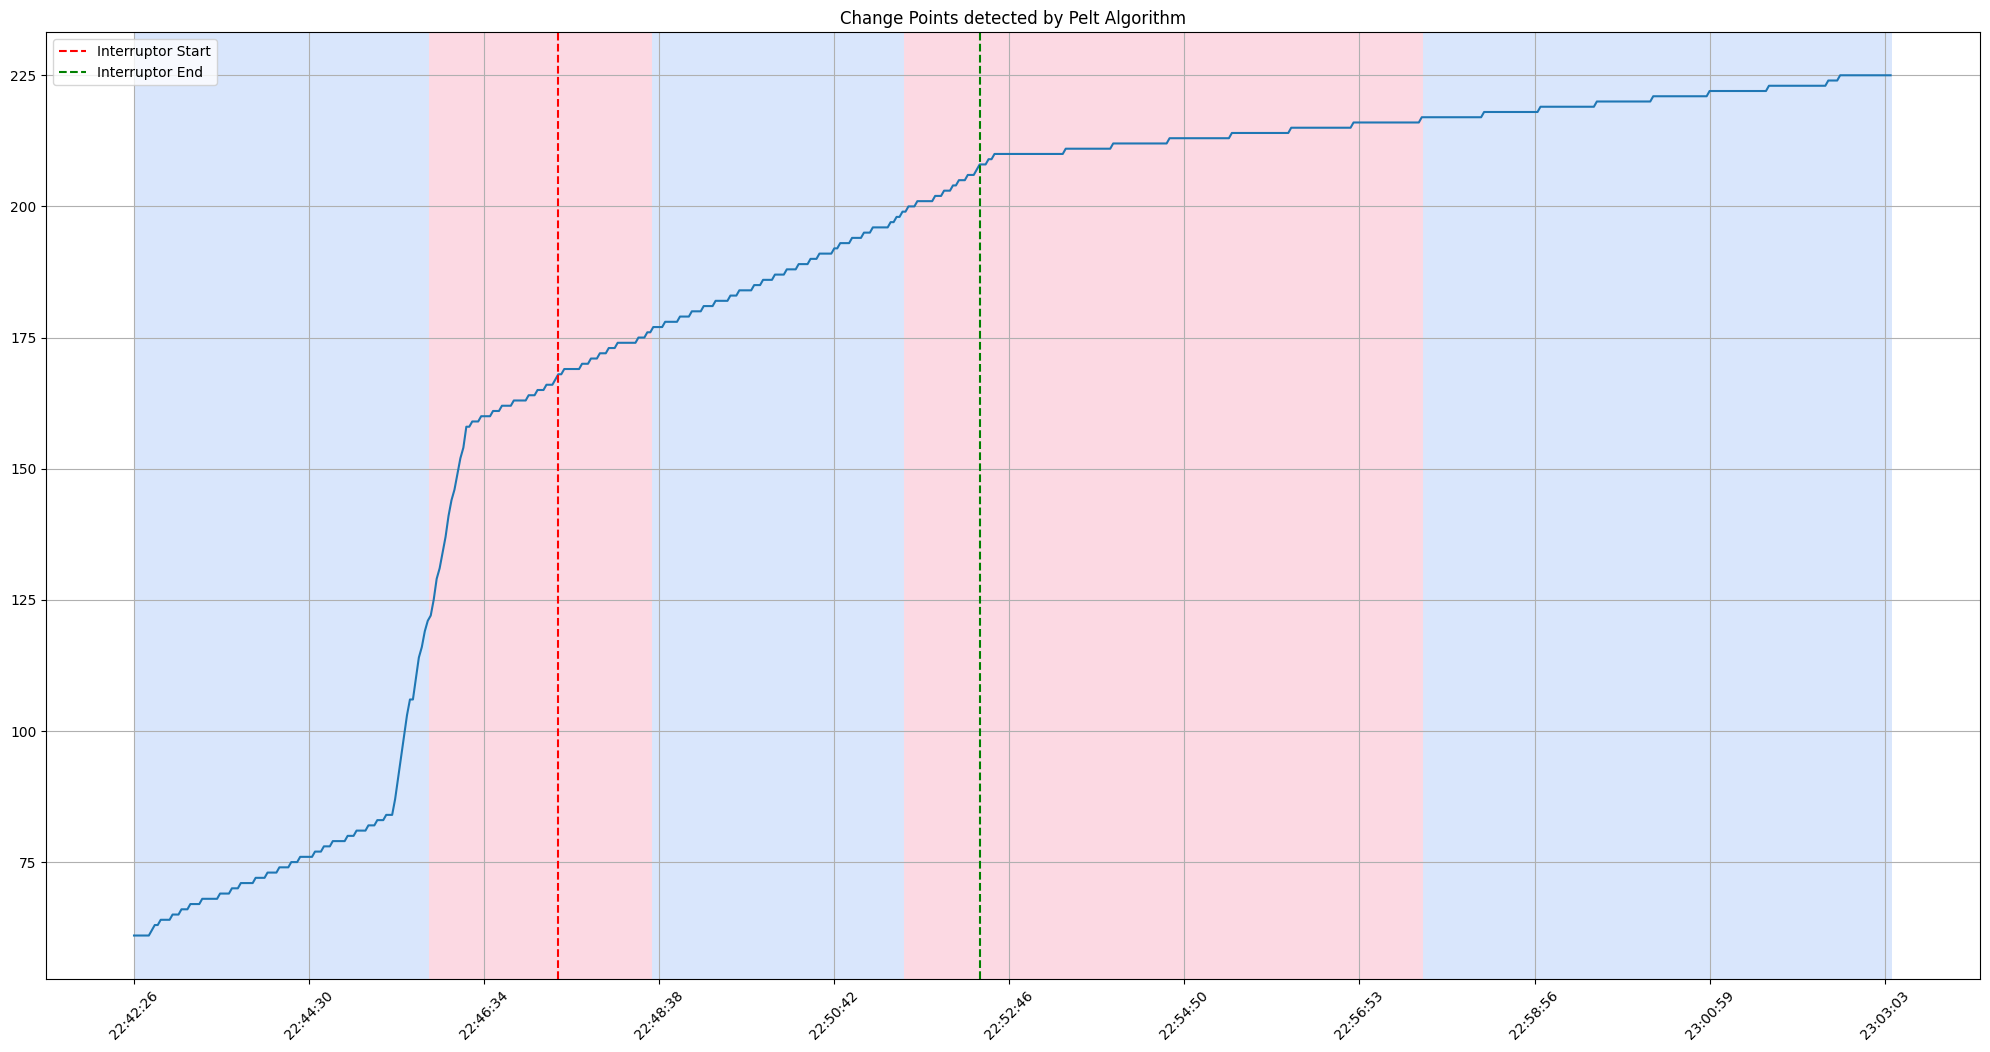

In [139]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df["Time"] = df["Time"].str.strip()
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Time"].values
indices = np.arange(len(signal))

start_time = df["Time"].min()
exact_time_5min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

signal = cpu_df["CPU Usage (seconds)"].values

model = "l1"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=400)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = cpu_df[cpu_df["Time"] == exact_time_5min].index[0]
index_10min = cpu_df[cpu_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
plt.grid(True)
plt.savefig("SYS/Plots/CPU_Usage_Change_Points_Pelt.png")
plt.show()

In [140]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.datetime objects
exact_time_5min = pd.to_datetime(exact_time_5min).to_pydatetime().time()
exact_time_10min = pd.to_datetime(exact_time_10min).to_pydatetime().time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Time"]):
        changepoint_timestamp = df["Time"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Result: FALSE


#### DP for memory usage

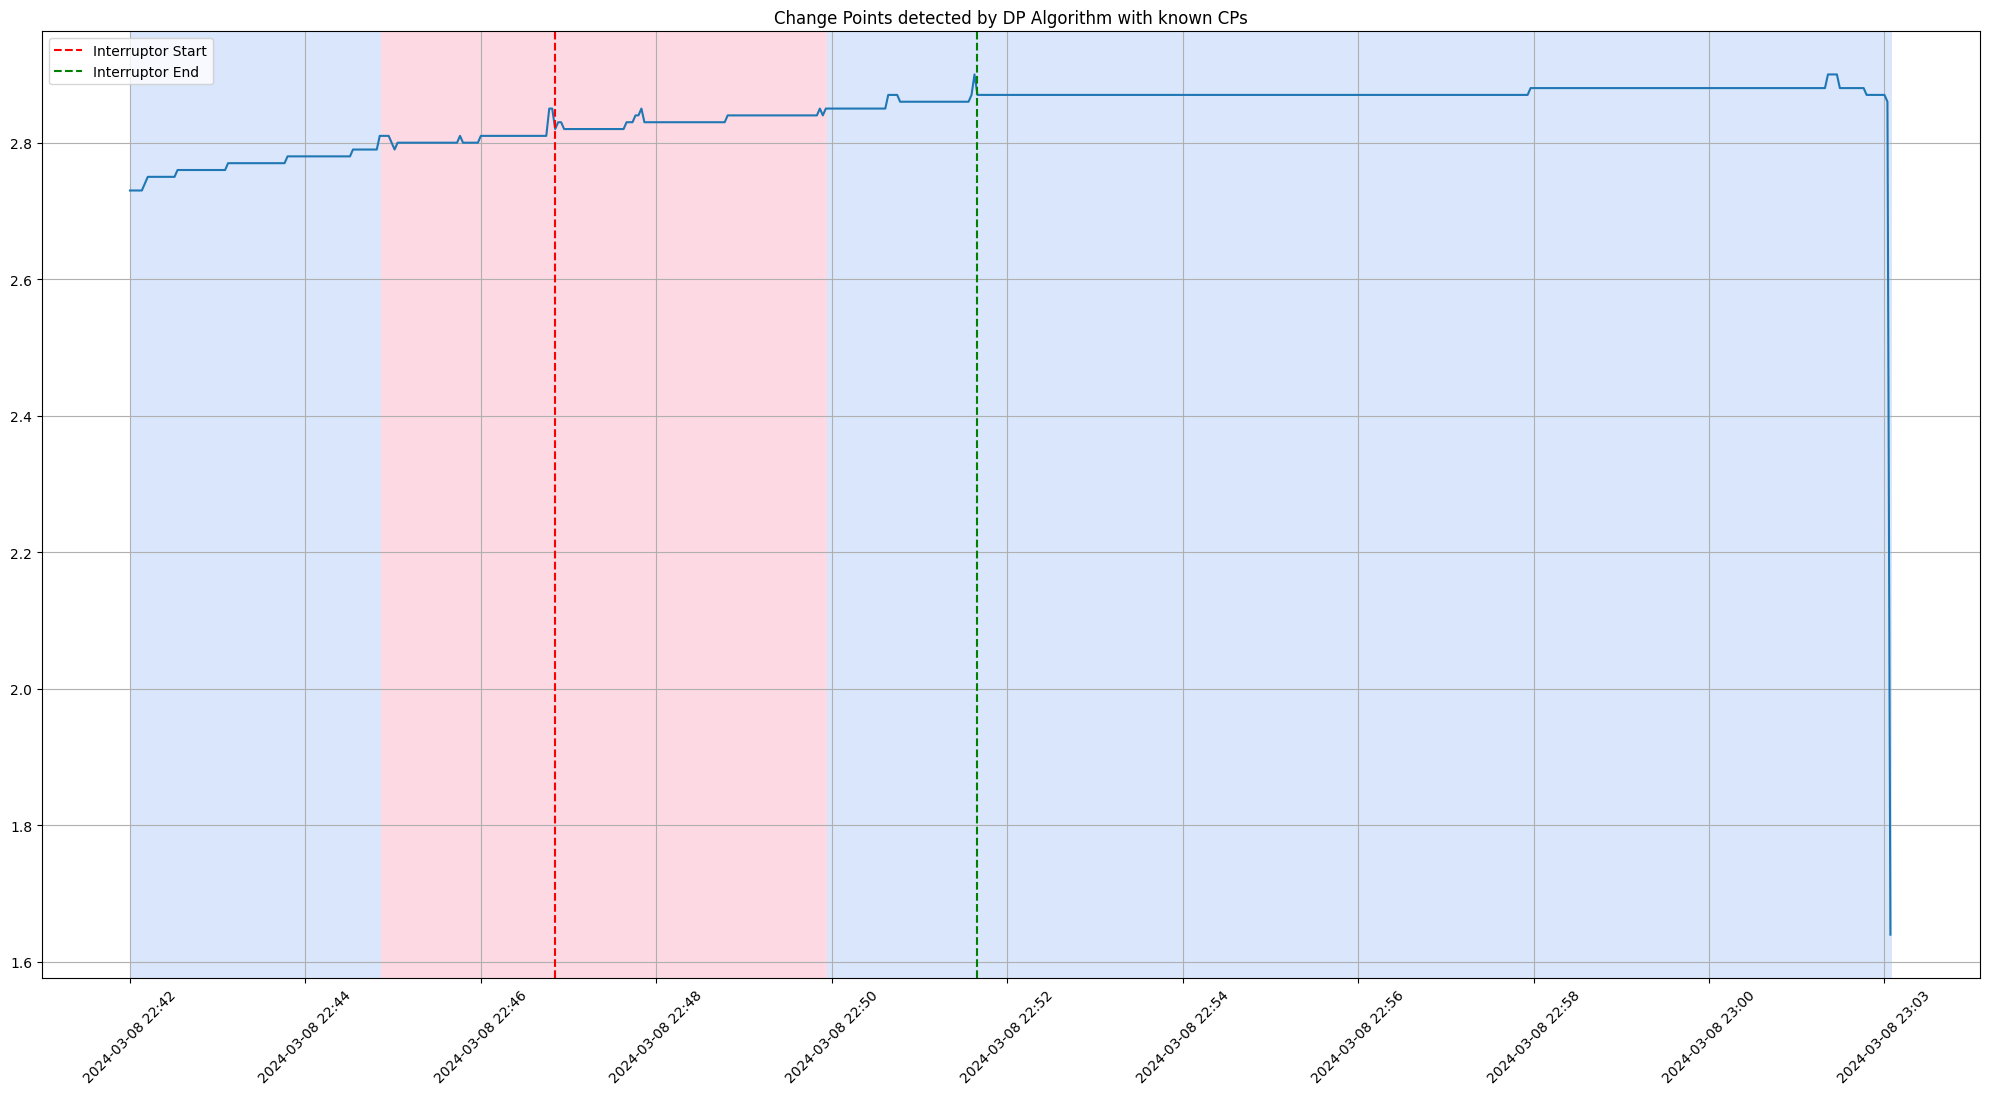

In [141]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df["Time"] = df["Time"].str.strip()
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

df["Memory Usage (current)"] = pd.to_numeric(df["Memory Usage (current)"].str.replace("GB", ""))
df["Memory Usage (peak)"] = pd.to_numeric(df["Memory Usage (peak)"].str.replace("GB", ""))

time_labels = df["Time"].values
indices = np.arange(len(signal))

start_time = df["Time"].min()
exact_time_5min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

model = "l1"
signal = df["Memory Usage (current)"].values  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = df["Time"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Time"] == exact_time_5min].index[0]
index_10min = df[df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.grid(True)
plt.savefig("SYS/Plots/Memory_Usage_Change_Points_DP.png")
plt.show()

In [142]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.datetime objects
exact_time_5min = pd.to_datetime(exact_time_5min).to_pydatetime().time()
exact_time_10min = pd.to_datetime(exact_time_10min).to_pydatetime().time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Time"]):
        changepoint_timestamp = df["Time"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Result: FALSE


#### DP for cpu usage

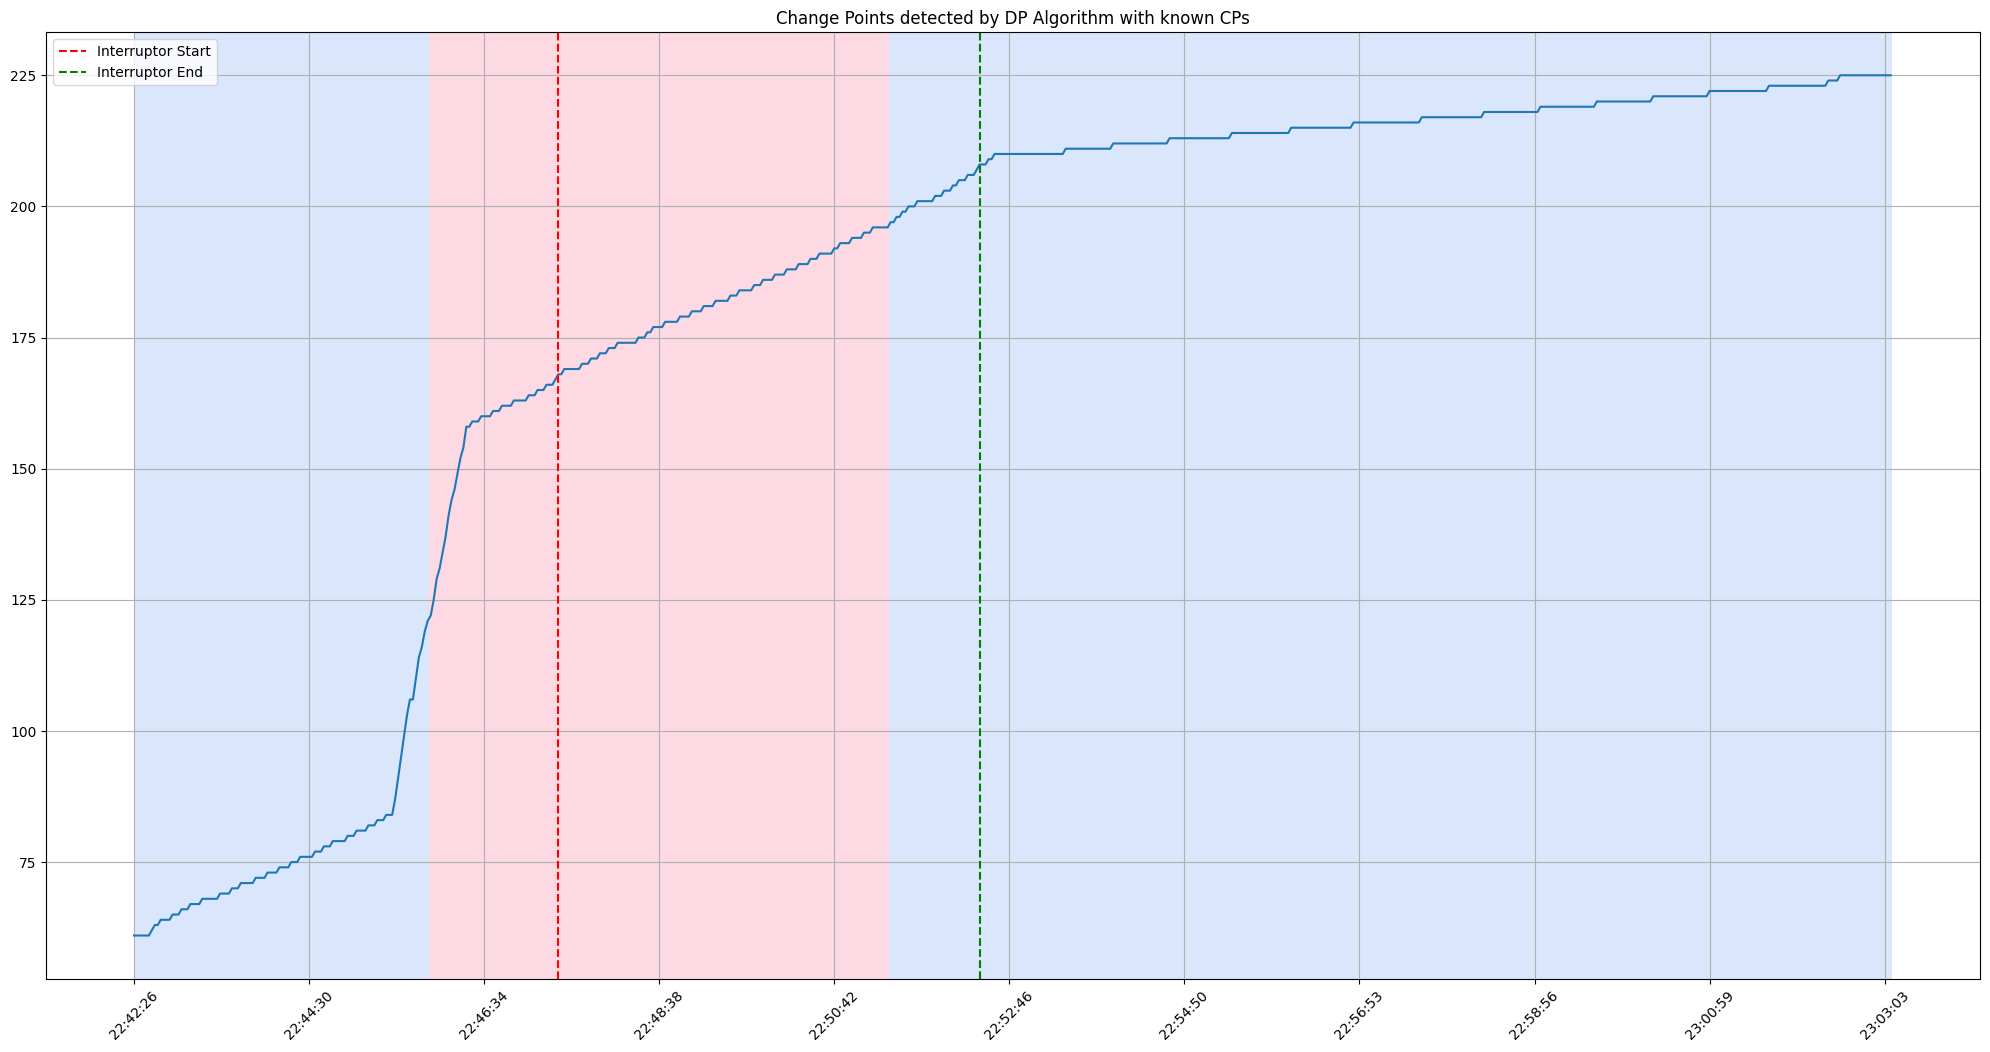

In [143]:
df = pd.read_csv("SYS/lxc_container_stats.csv")
df.columns = df.columns.str.strip()

df["Time"] = df["Time"].str.strip()
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Time"].values
indices = np.arange(len(signal))

start_time = df["Time"].min()
exact_time_5min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = df.iloc[(df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

exact_time_5min = cpu_df.iloc[(cpu_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = cpu_df.iloc[(cpu_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

signal = cpu_df["CPU Usage (seconds)"].values

model = "l1"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = cpu_df[cpu_df["Time"] == exact_time_5min].index[0]
index_10min = cpu_df[cpu_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")
plt.grid(True)
plt.legend()
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.savefig("SYS/Plots/CPU_Usage_Change_Points_DP.png")
plt.show()

In [144]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.datetime objects
exact_time_5min = pd.to_datetime(exact_time_5min).to_pydatetime().time()
exact_time_10min = pd.to_datetime(exact_time_10min).to_pydatetime().time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Time"]):
        changepoint_timestamp = df["Time"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Result: FALSE


# Metric: Transaction counts (#) 

## Formatting

#### Extract log

In [145]:
log_file_path = "TRT/filtered_transaction_data.log"

log_file_path = "TRT/filtered_transaction_data.log"
output_file_path = "TC/transaction_counts.log"
match_term = "TRANSACTION COUNT"

with open(log_file_path, "r") as file:
    lines = file.readlines()

# Find the index of the line that matches the term
match_index = next((index for index, line in enumerate(lines) if match_term in line), None)

if match_index is not None:
    # Write the lines from the match index to the end of the file to the output file
    with open(output_file_path, "w") as output_file:
            
        output_file.writelines(lines[match_index:])
        
else:
    print("Match term not found in the log file.")

    

#### CSV

In [146]:
# Filter the log file to remove unnecessary lines
counter_pattern = r'"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})": "(\d+)",'

log_file = "TC/transaction_counts.log"
output_file_path = "TC/transaction_counts.csv"

with open(log_file, "r") as file, open(output_file_path, "w") as output_file:

    output_file.write("Timestamp,Transaction_Count\n")

    for line in file:
        if re.match(counter_pattern, line.strip()):
            line = line.replace('"', '')
            count_colon = 0
            count_comma = 0
            new_line = ''
            for i in range(len(line)):
                if line[i] == ':':
                    count_colon += 1
                    if count_colon % 3 == 0:
                        new_line += ','  
                    else:
                        new_line += line[i]
                elif line[i] == ',':
                    count_comma += 1
                    if count_comma % 2 != 0:
                        new_line += line[i]
                else:
                    new_line += line[i]
            new_line = new_line.replace(', ', ',')  
            output_file.write(new_line)

## Preprocessing

#### Transaction counts (#)

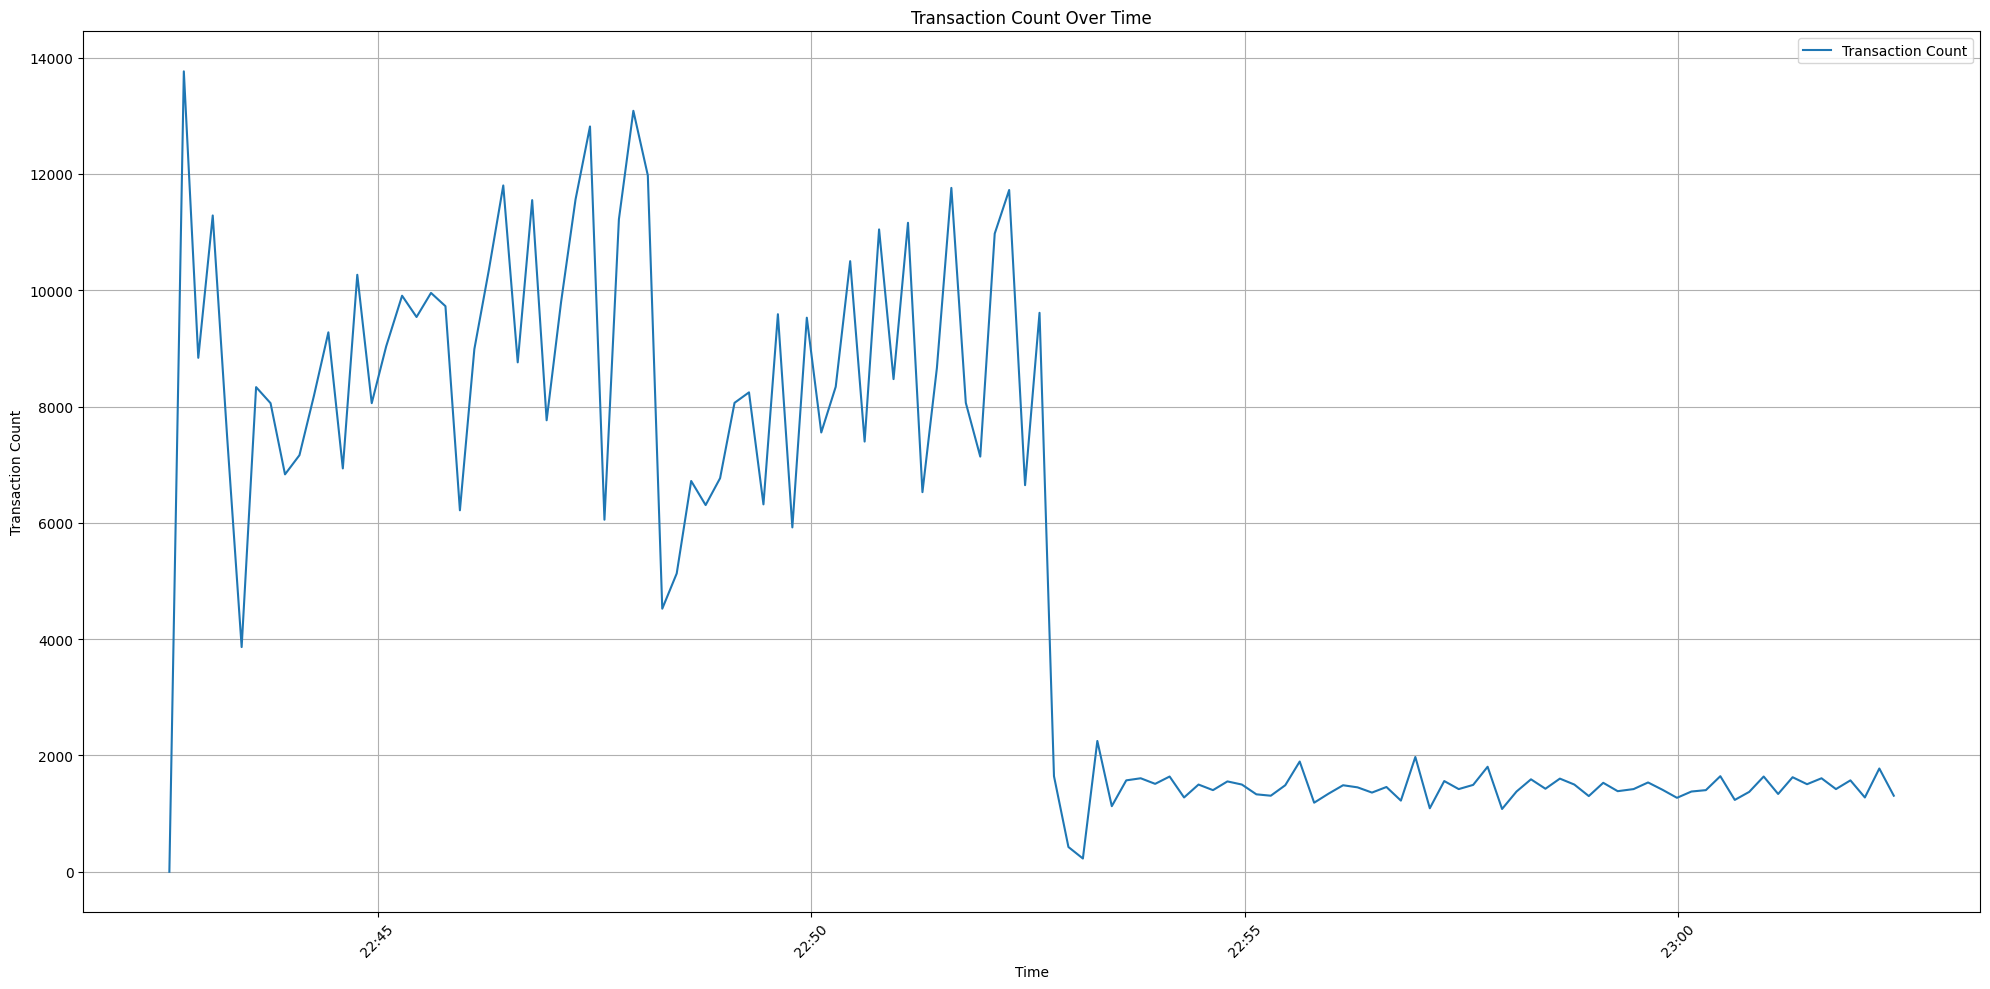

In [147]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

#print(df.head(5))

plt.figure(figsize=(20, 10))

plt.plot(df['Timestamp'], df['Transaction_Count'], label="Transaction Count", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")

plt.ylabel("Transaction Count")

plt.title("Transaction Count Over Time")

plt.grid(True)

plt.tight_layout()  

plt.legend()
plt.savefig("TC/Plots/Transaction_Count_Over_Time.png")
plt.show()

## CPD

#### Pelt

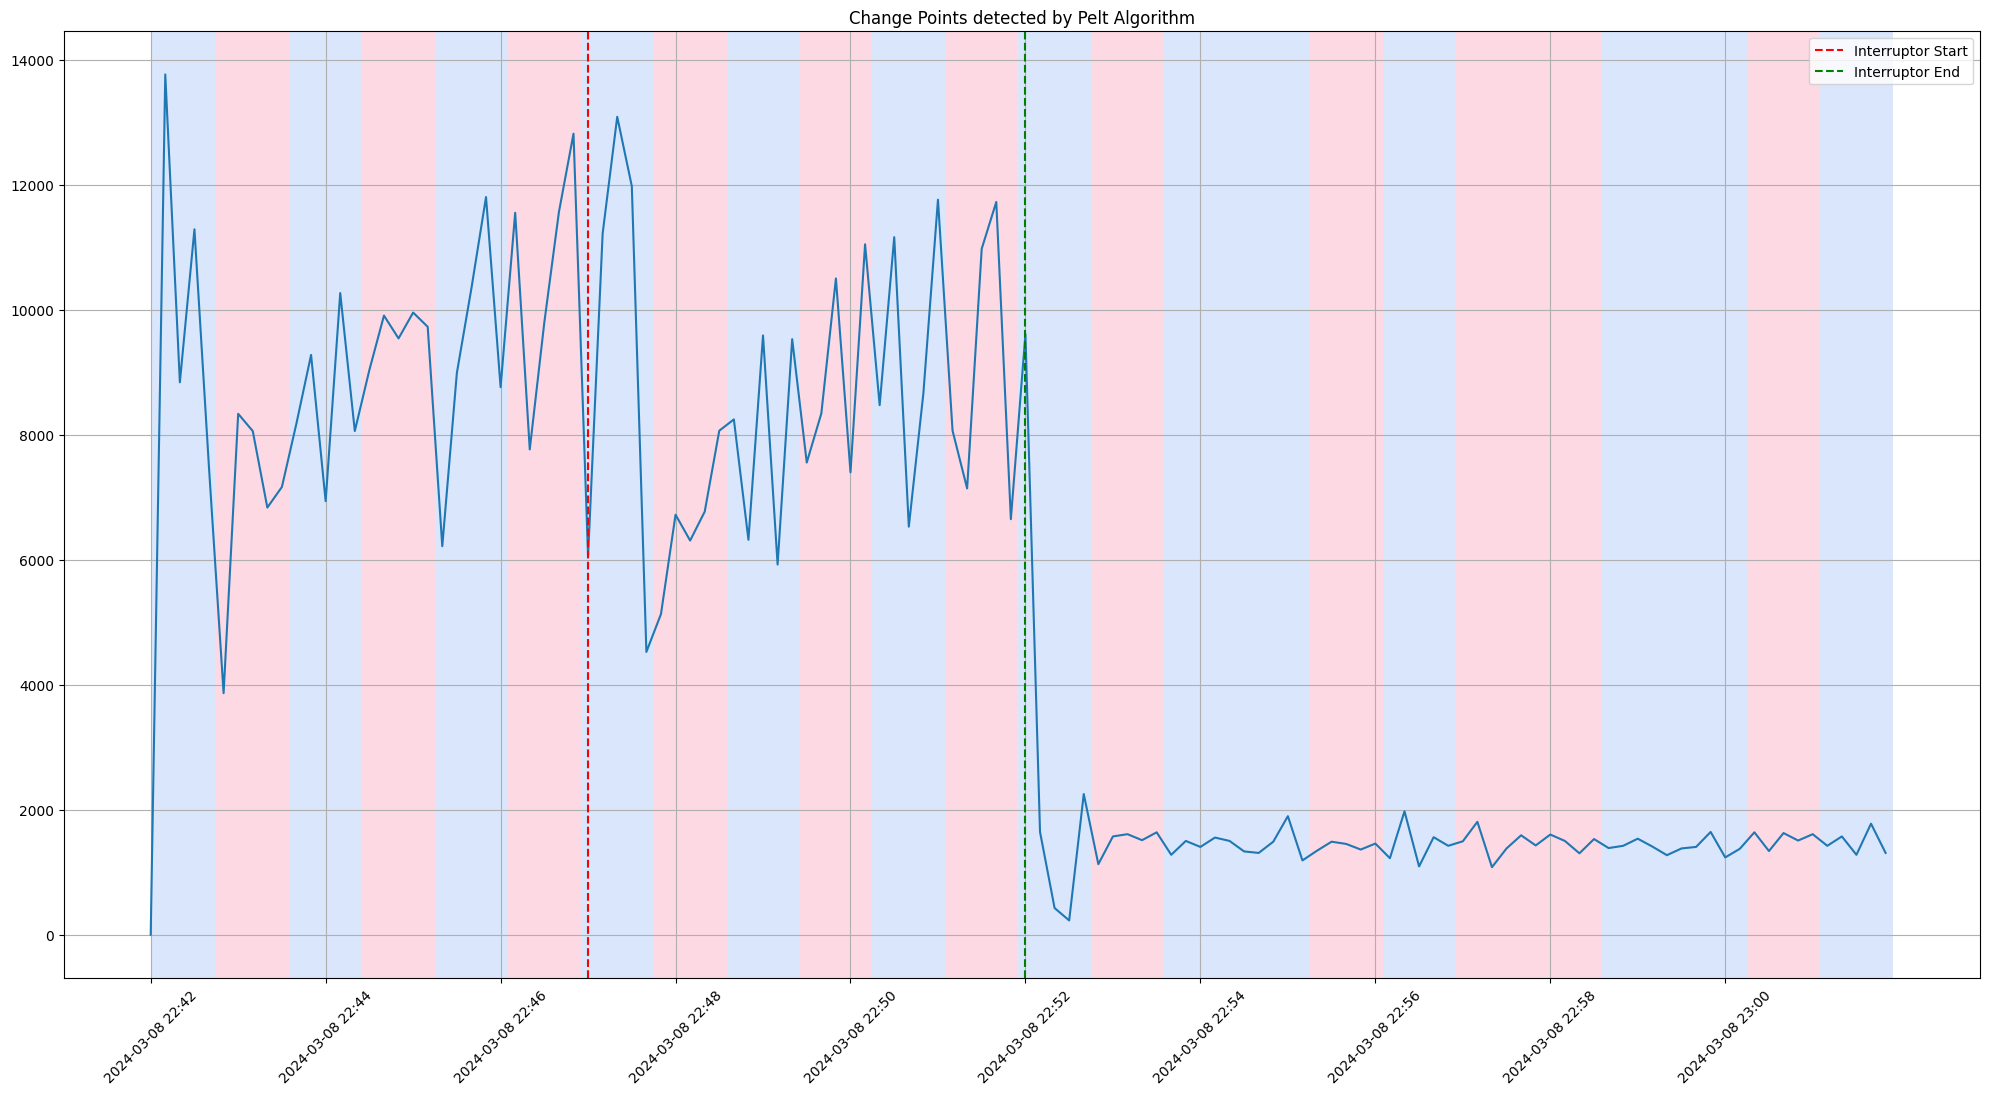

In [148]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Timestamp"].values
indices = np.arange(len(signal))

start_time = df["Timestamp"].min()
exact_time_5min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Timestamp"].values[0]
exact_time_10min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Timestamp"].values[0]

signal = df["Transaction_Count"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=150)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1
indices = np.arange(0, len(signal), step_size)
time_labels = df["Timestamp"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Timestamp"] == exact_time_5min].index[0]
index_10min = df[df["Timestamp"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.title("Change Points detected by Pelt Algorithm")
plt.grid(True)
plt.savefig("TC/Plots/Transaction_Count_Change_Points_Pelt.png")
plt.show()

In [149]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.time objects
exact_time_5min = pd.to_datetime(str(exact_time_5min)).time()
exact_time_10min = pd.to_datetime(str(exact_time_10min)).time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Timestamp"]):
        changepoint_timestamp = df["Timestamp"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Changepoint detected at 2024-03-08 22:47:27
Changepoint detected at 2024-03-08 22:52:28
Result: TRUE


#### DP

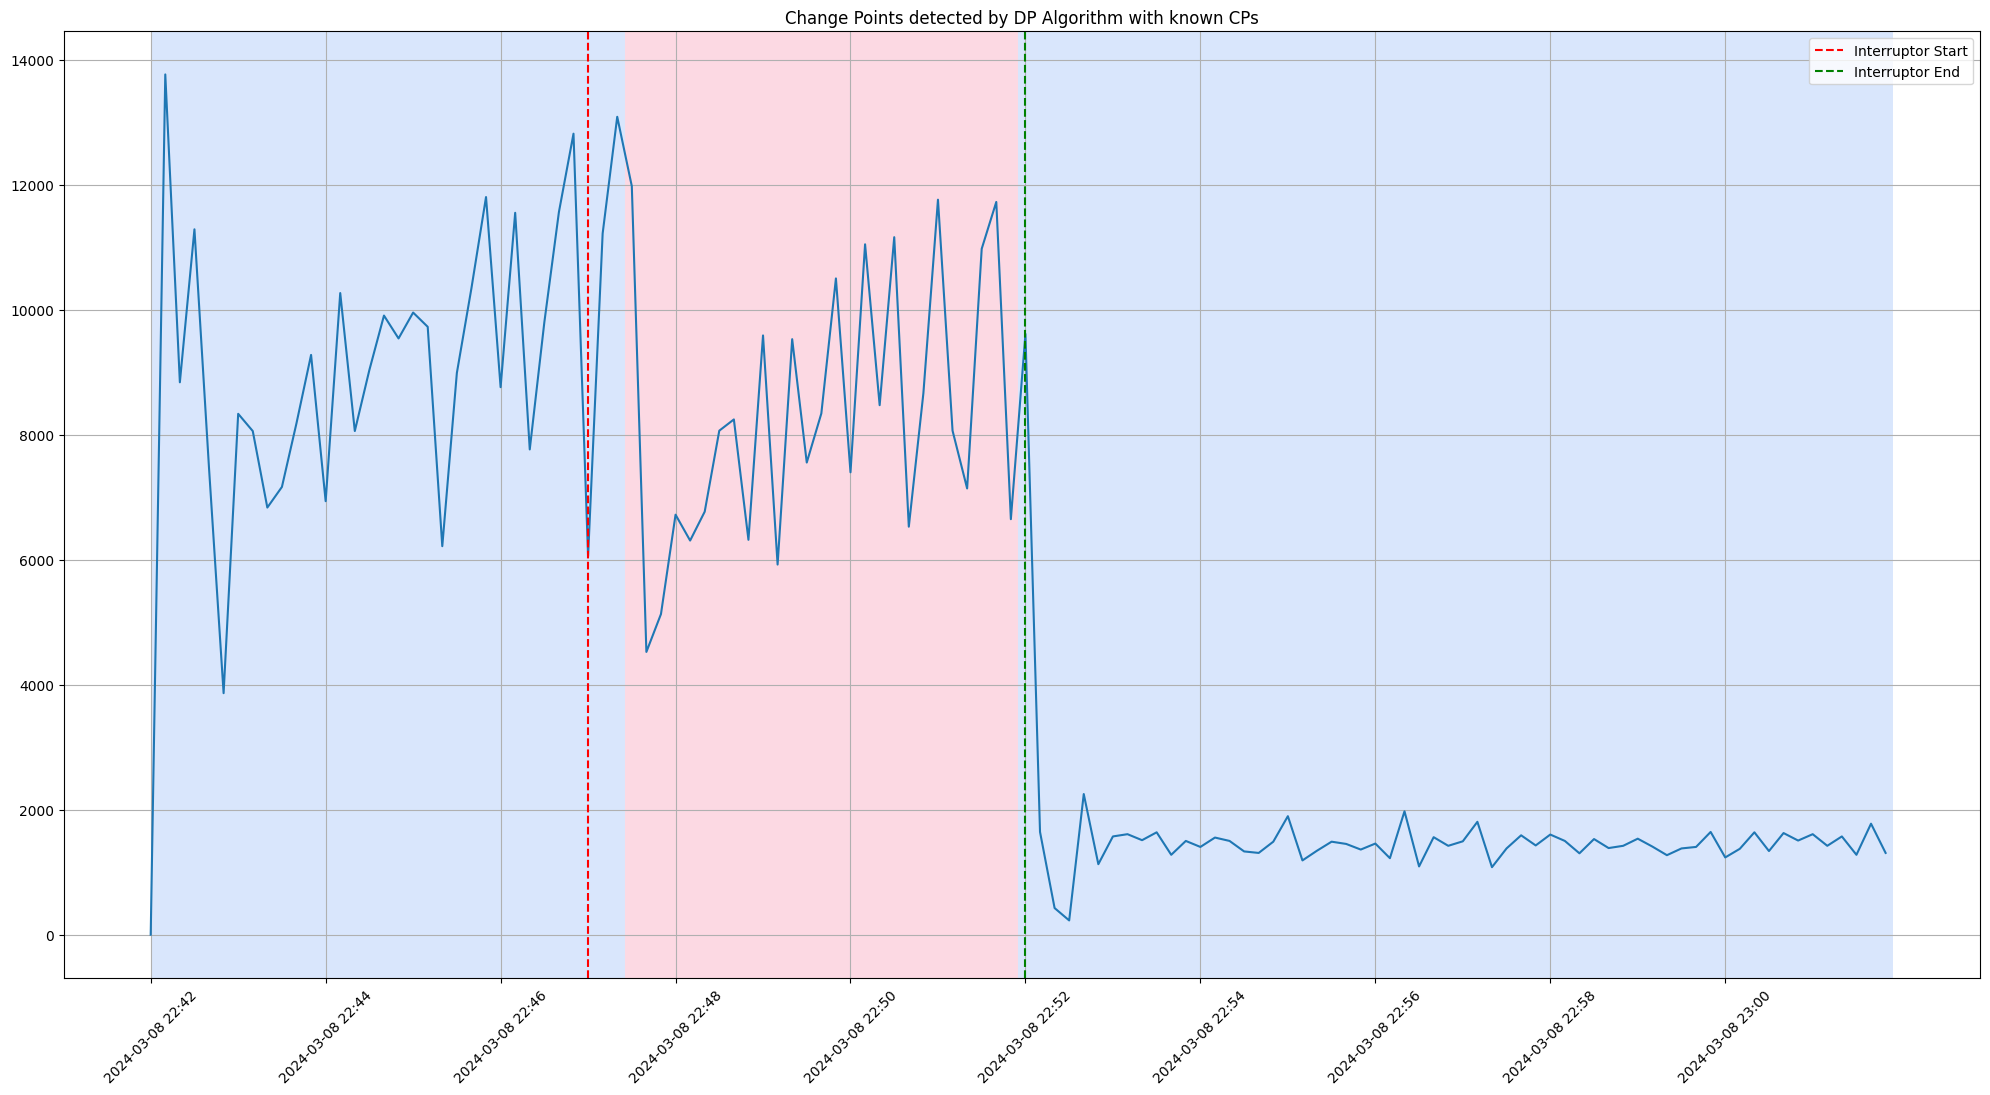

In [150]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Timestamp"].values
indices = np.arange(len(signal))

start_time = df["Timestamp"].min()
exact_time_5min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Timestamp"].values[0]
exact_time_10min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Timestamp"].values[0]           

signal = df["Transaction_Count"].values

model = "l1"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=3, jump=3).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1
indices = np.arange(0, len(signal), step_size)

time_labels = df["Timestamp"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Timestamp"] == exact_time_5min].index[0]
index_10min = df[df["Timestamp"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.grid(True)
plt.savefig("TC/Plots/Transaction_Count_Change_Points_DP.png")
plt.show()

In [151]:
from datetime import datetime, timedelta, date

# Subtract 1 from each index in result to match indices in df
adjusted_result = [idx - 1 for idx in result]
# Convert exact_time_5min and exact_time_10min to datetime.time objects
exact_time_5min = pd.to_datetime(str(exact_time_5min)).time()
exact_time_10min = pd.to_datetime(str(exact_time_10min)).time()

changepoint_timestamps = []

for idx in adjusted_result:
    if idx < len(df["Timestamp"]):
        changepoint_timestamp = df["Timestamp"].iloc[idx]
        changepoint_timestamps.append(changepoint_timestamp)
    else:
        print(f"Index {idx} is out of bounds for 'Time'")

first_changepoint = False
second_changepoint = False

for changepoint in changepoint_timestamps:
    # Convert changepoint to a datetime.time object
    changepoint_time = changepoint.time()

    # Calculate the difference in seconds between changepoint and exact_time_5min
    difference_five = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_5min
    )
    difference_in_seconds_five = difference_five.total_seconds()

    difference_ten = datetime.combine(date.min, changepoint_time) - datetime.combine(
        date.min, exact_time_10min
    )
    difference_in_seconds_ten = difference_ten.total_seconds()

    # Check if the difference is within 10 seconds
    if abs(difference_in_seconds_five) <= 10:
        print(f"Changepoint detected at {changepoint}")
        first_changepoint = True

    if abs(difference_in_seconds_ten) <= 10:
        print(f"Changepoint detected at {changepoint}")
        second_changepoint = True

if first_changepoint and second_changepoint:
    print("Result: TRUE")
else:
    print("Result: FALSE")

Changepoint detected at 2024-03-08 22:52:28
Result: FALSE
